In [1]:
import numpy as np
import matplotlib.pyplot as plt
from numba import njit
from scipy.stats import gaussian_kde

from sklearn.neighbors import KernelDensity
import pandas as pd

In [2]:
@njit
def runif(low,up):
    diff = up-low
    return np.random.rand(1) * diff + low

@njit
def gw_sample_eq(n,low,up,w,iters):
    samples = np.zeros((n,iters)) #, dtype=np.float)
    x = 0.
    x_temp = 0.
    found = False
    for k in range(iters):
        x = runif(low,up)
        for j in range(n):
            found = False
            while not found:
                x_temp = sample(x,w)
                if x_temp <= up and x_temp >= low:
                    samples[j,k] = x_temp[0]
                    found = True
                    x = x_temp
    return samples

@njit
def gw_sample_ineq(n,low,up,w,iters):
    samples = np.zeros((n,iters)) #, dtype=np.float)
    x = 0.
    x_temp = 0.
    low_arr = np.zeros(1)
    low_arr[0] = low
    up_arr = np.zeros(1)
    up_arr[0] = up
    for k in range(iters):
        x = runif(low,up)
        for j in range(n):
            x_temp = sample(x,w)
            if x_temp > up:
                x_temp = up_arr
            elif x_temp < low:
                x_temp = low_arr
            samples[j,k] = x_temp[0]
            x = x_temp
    return samples



@njit
def sample(x,w):
    return runif(low=x-w/2,up=x+w/2)

In [3]:
def expected_pdf(samples, low, up, n, bw, method="sklearn"):
    n_samples, n_iters = samples.shape
    dx = np.linspace(low, up, n)
    y = np.zeros((len(dx),n_iter))
    for i in range(n_iters):
        if method == "sklearn":
            kernel = KernelDensity(kernel='epanechnikov', bandwidth=bw).fit(samples[:,i].reshape(1,n_samples).T)
            y[:,i] = np.exp(kernel.score_samples(dx.reshape(1,-1).T))
        else: 
            kernel = gaussian_kde(samples[:,i].reshape(1,n_samples), bw_method=bw)
            y[:,i] = kernel.evaluate(dx.T)
    y = np.mean(y,axis=1)
    return y, dx


In [4]:
def plot_multiple(pdf_dict, label, save):
    fig = plt.figure(figsize=(10,10))
    for k,v in pdf_dict.items():
        plt.plot(v,label=k)
    plt.title(f"{label}")
    plt.grid()
    plt.legend()
    if save:
        plt.savefig(f"{label}.jpg")
    plt.show()
    

In [63]:
%%timeit
gw_sample_ineq(100,0.,1.,0.2,10)

468 µs ± 5.63 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [64]:
%%timeit
gw_sample_eq(100,0.,1.,0.2,10)

504 µs ± 786 ns per loop (mean ± std. dev. of 7 runs, 1000 loops each)


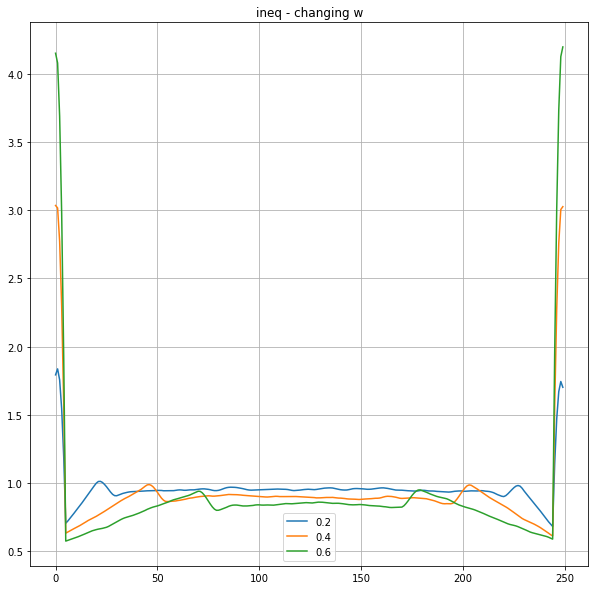

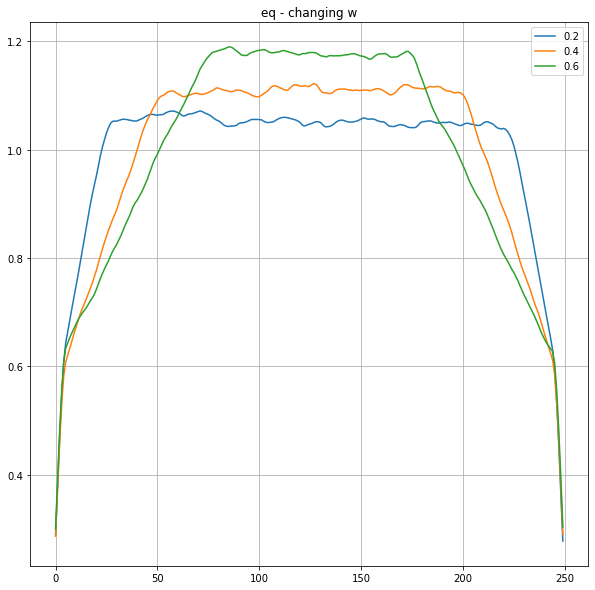

In [7]:
# rising w
#n_samples = 10000
#n_iter = 100
n_samples = 1000000
n_iter = 1

ws = [0.2,0.4,0.6]
low = 0.
up = 1.
ndx=250
bw=0.02


pdfs_ineq = {}
pdfs_eq = {}

for w in ws:
    samples = gw_sample_ineq(n_samples, low, up, w, n_iter)
    pdfs_ineq[w],xs = expected_pdf(samples,low,up,ndx,bw)
    samples = gw_sample_eq(n_samples, low, up, w, n_iter)
    pdfs_eq[w],xs = expected_pdf(samples,low,up,ndx,bw)

plot_multiple(pdfs_ineq,"ineq - changing w",True)
plot_multiple(pdfs_eq,"eq - changing w",True)



pdfs_ineq["x"] = xs
pdfs_eq["x"] = xs
pd.DataFrame(pdfs_ineq).to_csv("grid_walk_projection_continous_unit_line_w.csv")
pd.DataFrame(pdfs_eq).to_csv("grid_walk_rejection_continous_unit_line_w.csv")

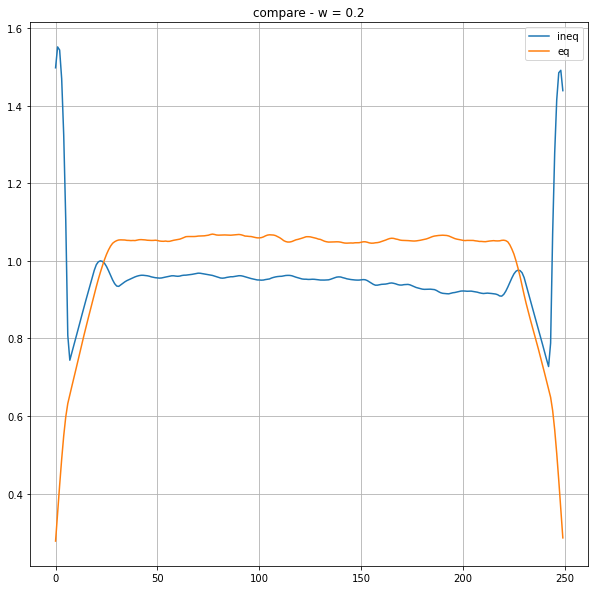

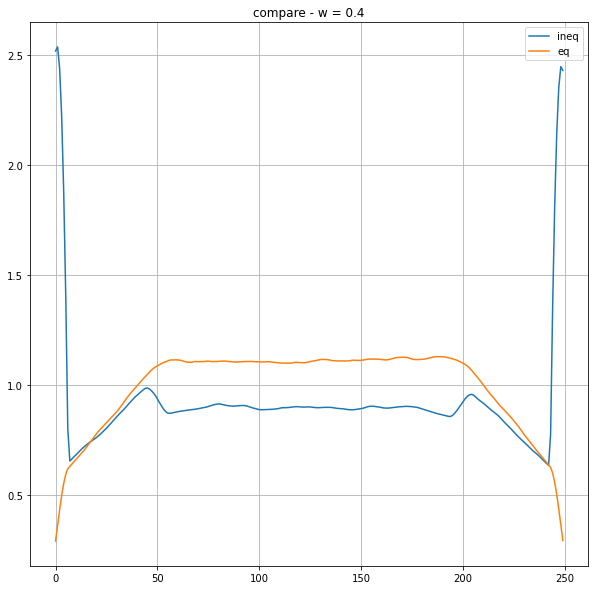

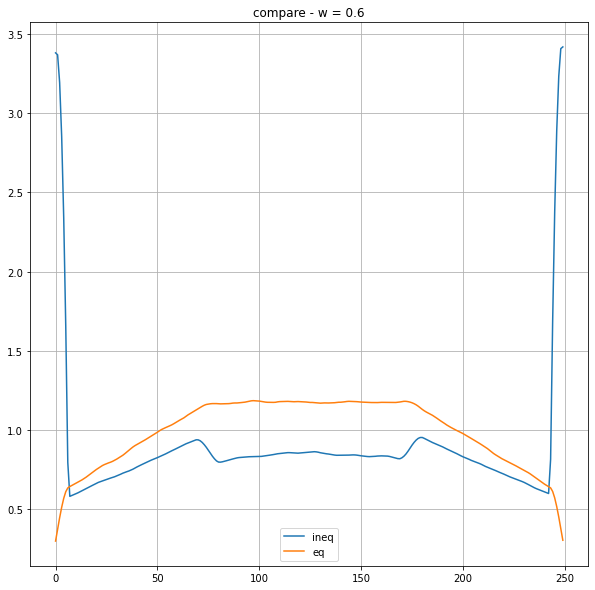

In [47]:
for k in pdfs_ineq.keys():
    pdf_pair = {}
    pdf_pair["ineq"] = pdfs_ineq[k]
    pdf_pair["eq"] = pdfs_eq[k]
    plot_multiple(pdf_pair,f"compare - w = {k}", True)
    

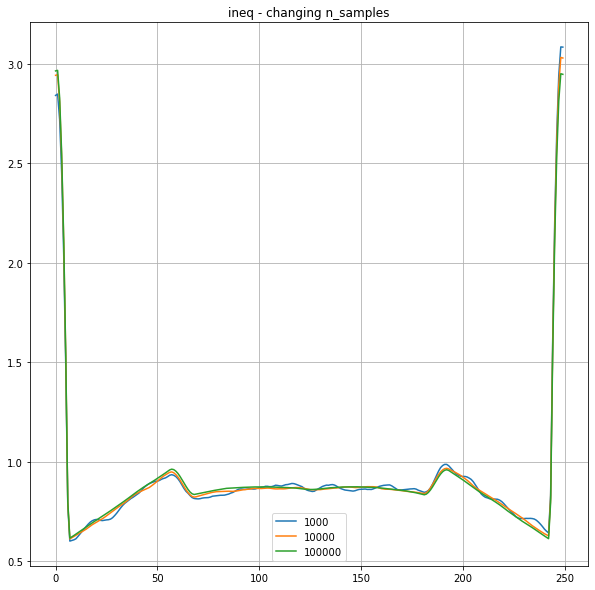

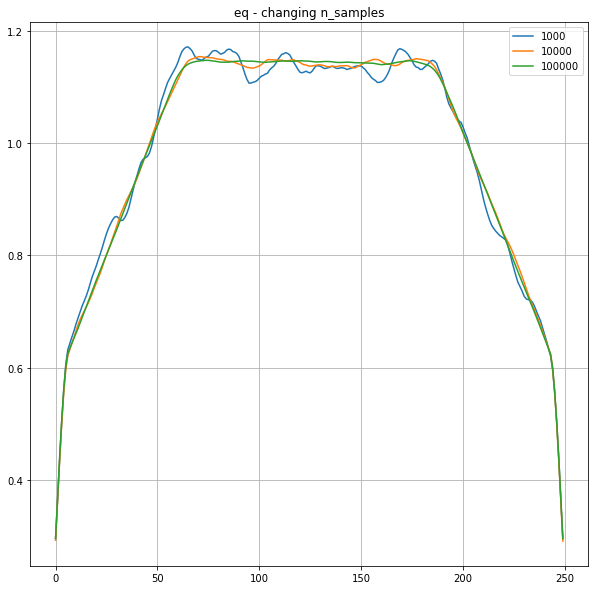

In [49]:
# rising n_samples
n_samples = [1000,10000,100000]
n_iter = 100
w = 0.5
low = 0.
up = 1.
ndx=250
bw=0.025


pdfs_ineq = {}
pdfs_eq = {}

for n in n_samples:
    samples = gw_sample_ineq(n, low, up, w, n_iter)
    pdfs_ineq[n] = expected_pdf(samples,low,up,ndx,bw)
    samples = gw_sample_eq(n, low, up, w, n_iter)
    pdfs_eq[n] = expected_pdf(samples,low,up,ndx,bw)

plot_multiple(pdfs_ineq,"ineq - changing n_samples", True)
plot_multiple(pdfs_eq,"eq - changing n_samples", True)
    

In [8]:
@njit
def nearest_neighbor(x, samples):
    current = 0
    min_dist = np.Inf
    for i in range(len(samples)):
        dist = (x - samples[i]) * (x - samples[i])
        if dist < min_dist:
            current = samples[i]
            min_dist = dist
    return current
        
@njit
def rrt(low, up, alpha, n, b_low, b_up, eqonly=True):
    root = runif(low,up)
    samples = np.zeros(n)
    samples[0] = root[0]
    found = False
    x_near = 0.
    for i in range(1,n):
        found = False
        while not found:
            x = runif(b_low, b_up)
            x_near = nearest_neighbor(x[0], samples[:i])
            x_new = x_near + np.sign(x - x_near)*alpha
            if x_new >= low and x_new <= up:
                samples[i] = x_new[0]
                found = True
            elif not eqonly:
                if x_new < low:
                    samples[i] = low
                    found =  True
                else:
                    samples[i] = up
                    found =  True
    return samples

@njit
def rrt_multiple(low,up,alpha,n,b_low,b_up,eq_only=True,iters=10):
    samples = np.zeros((n,iters))
    for i in range(iters):
        samples[:,i] = rrt(low,up,alpha,n,b_low,b_up,eq_only)
    return samples

In [9]:
# rrt rising 
bounds = [0.3,0.5,0.7]
n_samples = 1000000
ns = [1000, 2000, 5000]
alpha = 0.0005
alphas = [alpha,alpha*2,alpha*3,alpha*4,alpha*5]
pdfs_rrt_eq = {}
pdfs_rrt_ineq = {}
#pdfs_rrt_ineq_n = {}
for b in bounds:
    samples = rrt_multiple(low,up,alpha,n_samples, 0-b,1+b,False,n_iter)
    pdfs_rrt_ineq[b],xs = expected_pdf(samples,low,up,ndx,bw)

for b in bounds:
    samples = rrt_multiple(low,up,alpha,n_samples, 0-b,1+b,True,n_iter)
    pdfs_rrt_eq[b],xs = expected_pdf(samples,low,up,ndx,bw)
    
    
#for a in alphas:
#    samples = rrt_multiple(low,up,a,n_samples, bounds[2]*-1,bounds[2]+1,True,n_iter)
#    pdfs_rrt_eq[a],xs = expected_pdf(samples,low,up,ndx,bw)

#for ni in ns:
#    samples = rrt_multiple(low,up,a,ni, bounds[-1]*-1,bounds[-1]+1,False,n_iter)
#    pdfs_rrt_ineq_n[ni],xs = expected_pdf(samples,low,up,ndx,bw)
    
    
#plot_multiple(pdfs_rrt_eq,"eq - changing alpha",True)
plot_multiple(pdfs_rrt_ineq,"ineq - changing bounds",True)
pdfs_rrt_ineq["x"] = xs
pd.DataFrame(pdfs_rrt_ineq).to_csv("rrt_projection_continous_unit_line_b.csv")
plot_multiple(pdfs_rrt_eq,"eq - changing bounds",True)
pdfs_rrt_eq["x"] = xs
pd.DataFrame(pdfs_rrt_eq).to_csv("rrt_rejection_continous_unit_line_b.csv")

#plot_multiple(pdfs_rrt_ineq_n,"ineq - changing n_samples",True)


KeyboardInterrupt: 

In [20]:
samples.shape

(10000, 100)

In [ ]:
#without ineq
def kernel_mean(samples, multiple, note):
    l = len(samples)
    if multiple:
        dx = np.linspace(0,1,250)
        iters = samples.shape[2]
        y = np.zeros(iters*len(dx)).reshape(len(dx),iters)    
        for k in range(iters):
                kernel = gaussian_kde(samples[:,0,k].reshape(1,l), bw_method=0.2)
                y[:,k] = kernel.evaluate(dx.T)
        y = np.mean(y,axis=1)
    for i,w in enumerate(ws):
        if not multiple:
            kernel = gaussian_kde(samples[:,i].reshape(1,l), bw_method=0.2)
            dx = np.linspace(0,1,250)
            y = kernel.evaluate(dx.T)
    return y
#        plt.plot(y,label=np.round(w,2))
#        plt.xticks(dx)
#        plt.title(f"n = {l}, {note}")
#    plt.legend()
#    plt.show()
              

In [53]:
n = [1000,10000,100000] 
low = 0
up = 1

#ws = np.arange(0.1,0.5,0.1)
ws = [0.4]
eq = {}
ineq = {}

for ni in n:
    samples = np.zeros(int(ni)*len(ws)*100).reshape(int(ni),len(ws),100) 
    for k in range(100):
        for i,w in enumerate(ws):
            x = np.random.uniform(low,up)
            for j in range(ni):
                found = False
                while not found:
                    x_temp = sample(x,w)
                    if x_temp <= up and x_temp >= low:
                        samples[j,i,k] = x_temp
                        found = True
                        x = x_temp      
    #plotting(samples, True,"eq")
    eq[ni] = kernel_mean(samples,True,"eq")
    samples2 = np.zeros(int(ni)*len(ws)*100).reshape(int(ni),len(ws),100)
    for k in range(100):
        for i,w in enumerate(ws):
            x = np.random.uniform(low,up)
            for j in range(ni):
                x_temp = sample(x,w)
                if x_temp < low:
                    samples2[j,i,k] = low    
                    x = low
                elif x_temp > up:
                    samples2[j,i,k] = up
                    x = up
                else:
                    samples2[j,i,k] = x_temp
                    x = x_temp
    ineq[ni] = kernel_mean(samples2,True,"eq")

    #plotting(samples2,True,"ineq")


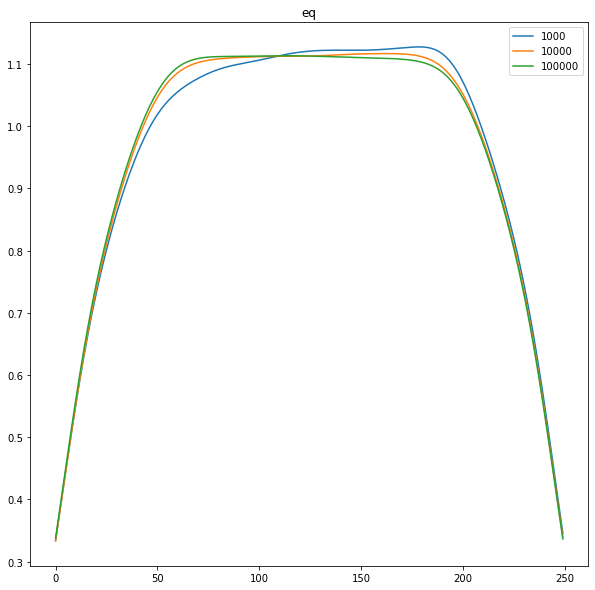

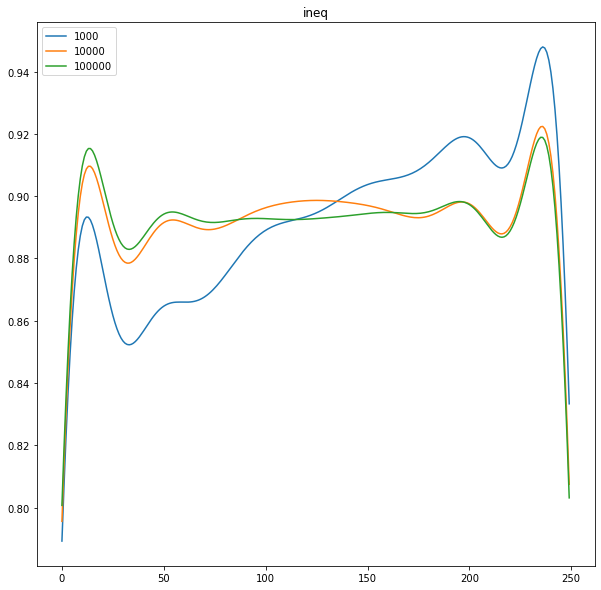

In [54]:
def plotting(data_dict, label):
    fig = plt.figure(figsize=(10,10))
    for k,v in data_dict.items():
        plt.plot(v,label=k)
    #plt.xticks(dx)
    plt.title(f"{label}")
    plt.legend()
    plt.show()
    
plotting(eq,"eq")
plotting(ineq,"ineq")
    

In [65]:
%%timeit
randomm(1,2)

427 ns ± 7.9 ns per loop (mean ± std. dev. of 7 runs, 1000000 loops each)


In [66]:
def randommm(low,up):
    diff = up-low
    return np.random.rand(1) * diff + low

In [68]:
%%timeit
np.random.uniform(1,2)

1.51 µs ± 51.1 ns per loop (mean ± std. dev. of 7 runs, 1000000 loops each)


In [ ]:
%%timeit
randomm(1,2)

420 ns ± 7.12 ns per loop (mean ± std. dev. of 7 runs, 1000000 loops each)


In [ ]:
n = [10000] 
low = 0
up = 1

#ws = np.arange(0.1,0.5,0.1)
ws = [0.2,0.3,0.4]
eq = {}
ineq = {}

for ni in n:
    samples = np.zeros(int(ni)*len(ws)*100).reshape(int(ni),len(ws),100) 
    for k in range(100):
        for i,w in enumerate(ws):
            x = np.random.uniform(low,up)
            for j in range(ni):
                found = False
                while not found:
                    x_temp = sample(x,w)
                    if x_temp <= up and x_temp >= low:
                        samples[j,i,k] = x_temp
                        found = True
                        x = x_temp
            
    #plotting(samples, True,"eq")
    eq[ni] = kernel_mean(samples,True,"eq")
    samples2 = np.zeros(int(ni)*len(ws)*100).reshape(int(ni),len(ws),100)
    for k in range(100):
        for i,w in enumerate(ws):
            x = np.random.uniform(low,up)
            for j in range(ni):
                x_temp = sample(x,w)
                if x_temp < low:
                    samples2[j,i,k] = low    
                    x = low
                elif x_temp > up:
                    samples2[j,i,k] = up
                    x = up
                else:
                    samples2[j,i,k] = x_temp
                    x = x_temp
    ineq[ni] = kernel_mean(samples2,True,"eq")

    #plotting(samples2,True,"ineq")


IndexError: index 4 is out of bounds for axis 1 with size 4

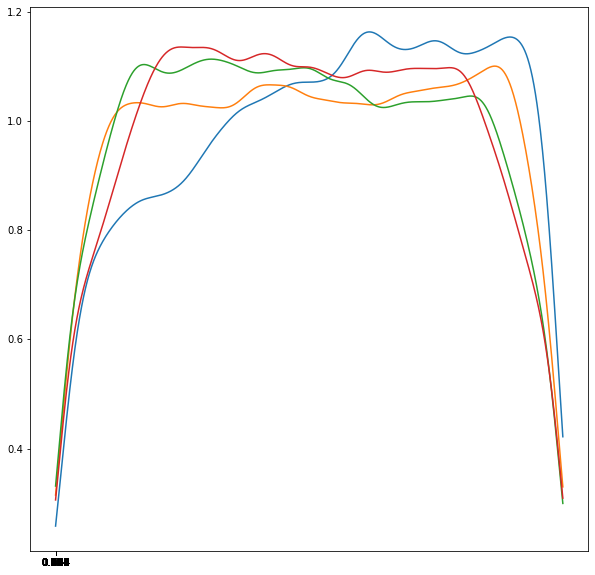

In [58]:
#without ineq
l = len(samples)data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAAlMAAAJOCAYAAACTCYKtAAAAOXRFWHRTb2Z0d2FyZQBNYXRwbG90bGliIHZlcnNpb24zLjMuMiwgaHR0cHM6Ly9tYXRwbG90bGliLm9yZy8vihELAAAACXBIWXMAAAsTAAALEwEAmpwYAACCX0lEQVR4nOzdd3icV53+//eZot57m1Gx5N5jOz2kEBIHSGibwi5JKMsXWMrCb1myy8KSbYRlK2WBsGEJNYUWAiGFBCchzSXuVbJ6771MO78/RlZcZFu2Jc1Iul/XNZc053lm9JHsWHfOc57PMdZaREREROT8OCJdgIiIiMhcpjAlIiIicgEUpkREREQugMKUiIiIyAVQmBIRERG5AApTIiIiIhdAYUpEopoxZr8x5upI1yEicjpGfaZEREREzp9mpkREREQugMKUiEQ1Y0ytMebNxpgvGWMeMcb8wBgzMH75b8Nx5xUYY35ujOkwxtQYYz553LF4Y8z3jTE9xpgDxpjPGmMaI/Mdich8ozAlInPJzcBDQBrwa+AbAMYYB/A4sBsoBK4D/tIYc8P46/4eWDT+uAG4a1arFpF5TWFKROaSP1prn7DWBoEfAmvGxzcC2dbaf7DW+qy11cB3gdvHj98K/LO1ttta2wB8bdYrF5F5yxXpAkREzkHrcZ8PA3HGGBdQDBQYY3qPO+4EXhz/vABoOO5Y3UwWKSILi8KUiMwHDUCNtbbiNMdbAA+wf/y5d1aqEpEFQZf5RGQ+2Ar0G2M+N77Y3GmMWWmM2Th+/BHgb4wx6caYIuATkStVROYbhSkRmfPG11C9HVgL1ACdwP8CqeOn3Ev40l4N8DTh9VYiItNCTTtFZMEZ76j+I2ttUYRLEZF5QDNTIiIiIhdAYUpERETkAugyn4iIiMgF0MyUiIiIyAWIWJ+prKwsW1JSEqkvLyIiIjJlO3bs6LTWZk92LGJhqqSkhO3bt0fqy4uIiIhMmTHmtDsn6DKfiIiIyAVQmBIRERG5AApTIiIiIhdAGx2LiIgsEH6/n8bGRkZHRyNdStSKi4ujqKgIt9s95dcoTImIiCwQjY2NJCcnU1JSgjEm0uVEHWstXV1dNDY2UlpaOuXX6TKfiIjIAjE6OkpmZqaC1GkYY8jMzDznmTuFKRERkQVEQerMzufnozAlIiIicgEUpkRERGTWfOADHyAnJ4eVK1dOjHV3d3P99ddTUVHB9ddfT09Pz8SxL3/5y5SXl7NkyRKeeuqpifEdO3awatUqysvL+eQnP0kk9xpWmBIREZFZc/fdd/Pkk0+eMHbfffdx3XXXUVlZyXXXXcd9990HwIEDB3jooYfYv38/Tz75JB/72McIBoMAfPSjH+X++++nsrKSysrKU95zNilMiYiIyKy56qqryMjIOGHsscce46677gLgrrvu4le/+tXE+O23305sbCylpaWUl5ezdetWWlpa6O/v59JLL8UYw5133jnxmkhQawQREZEF6N7H93OguX9a33N5QQp///YV5/y6trY28vPzAcjPz6e9vR2ApqYmLrnkkonzioqKaGpqwu12U1RUdMp4pGhmSkRERKLSZOugjDGnHY8UzUyJiIgsQOczgzRTcnNzaWlpIT8/n5aWFnJycoDwjFNDQ8PEeY2NjRQUFFBUVERjY+Mp45GimSkRERGJqJtvvpkHH3wQgAcffJBbbrllYvyhhx5ibGyMmpoaKisr2bRpE/n5+SQnJ/Pqq69ireUHP/jBxGsiQTNTIiIiMmvuuOMOtmzZQmdnJ0VFRdx7773cc8893HrrrTzwwAN4vV4effRRAFasWMGtt97K8uXLcblcfPOb38TpdALwrW99i7vvvpuRkRE2b97M5s2bI/Y9mUj1ZdiwYYPdvn17RL62iIjIQnTw4EGWLVsW6TKi3mQ/J2PMDmvthsnO12U+ERERkQugMCUiIiJyARSmRERERC6AwpSIiIjIBVCYEhEREbkAao0gIiKzZiwQpHPQR8fA2MSjZ9jHwGiAobHwY3AswJAvwIgvSNBCKGQJhiwhG35YCzEuB3FuJ7HHfYx3O0lNcJOREEN6YgwZiTEUpMXjSY8nIzEmoh2yZX5TmBIRkWkTClla+0ep7Rqirmt4/DFEbdcwzb0j9I34J32d22lIjHWRGOMiKdZFYqyThBgXDofBacDpMDiMwekIByJfIMRYIMSoP8jAaICxQJBhX5C+YT8DY4FT3j8hxoknPYElecmsLExhZUEqKwpSSU1wz+jPQ071gQ98gN/85jfk5OSwb98+ALq7u7ntttuora2lpKSERx55hPT0dAC+/OUv88ADD+B0Ovna177GDTfcAMCOHTsm+kzddNNN/Pd//zfGGMbGxrjzzjvZsWMHmZmZPPzww5SUlMzo96QwJSIi52VoLMCh1gEOtvRPPA61DjDsC06c43YaPBkJlGQmsqE4nZzkWLJPemQkxhDrck5bXb5AiN5hH52DPpp6R2joHqaxZ4T67iF21PXw693NE+cuy0/hmiXZXLM0h3WeNFxOrX6ZaXfffTcf//jHufPOOyfG7rvvPq677jruuece7rvvPu677z6+8pWvcODAAR566CH2799Pc3Mzb37zmzly5AhOp5OPfvSj3H///VxyySXcdNNNPPnkk2zevJkHHniA9PR0qqqqeOihh/jc5z7Hww8/PKPfk8KUiIicVShkqeoYZEddD6/X9fB6fQ/VnUMc6/ucHOdiWX4Kt27wUJ6TRGlWIt6MBArS4idmk2ZLjMtBTkocOSlxLC9IOeV495CPfU197Gns5cXKTr7zQjX/s+UoKXEubliRx3suKmJTaYYuC86Qq666itra2hPGHnvsMbZs2QLAXXfdxdVXX81XvvIVHnvsMW6//XZiY2MpLS2lvLycrVu3UlJSQn9/P5deeikAd955J7/61a/YvHkzjz32GF/60pcAeM973sPHP/5xrLUz+uepMCUiIqfwB0Psbujl5aNdbK/rYWd9DwOj4ctn6QluLipO5+Y1hSwvSGFZfjKFafFzJnxkJMZw1eJsrlqczcevraBvxM9LVZ38/mAbT+xt4dEdjSzKTuSDV5TxrvWFxLmnb9YsqvzuHmjdO73vmbcKNt93zi9ra2sjPz8fgPz8fNrb2wFoamrikksumTivqKiIpqYm3G43RUVFp4wfe43H4wHA5XKRmppKV1cXWVlZ5/1tnY3ClIiIEApZDrUO8PLRTl6q6mRrTTdDviDGwJLcZN62uoCLitO5qDidksyEOROcpiI13s1Nq/K5aVU+w+8I8Lu9rfzfyzX87S/38l+/P8Inrqvgtg0eYly6BDjbJtvyzhhz2vEzvWYmKUyJiCxQfSN+Xqzs4LlD7Tx/uIOuIR8AZVmJvHN9IZcvyuKSskzSE2MiXOnsSYhx8e6LinjX+kJeqe7iP585whd+tY//+2MN/3DLSq6omLnZjVl3HjNIMyU3N5eWlhby8/NpaWkhJycHCM84NTQ0TJzX2NhIQUEBRUVFNDY2njJ+/GuKiooIBAL09fWRkZExo/UrTImILBDWWo52DPGHQ+08e6iN7bU9BEKWtAQ3b1qczZUV2Vxenkl+anykS404YwyXLcri0rJMnjvUzj/85gB/9sBrvGNtAffespLUeN0FOJ1uvvlmHnzwQe655x4efPBBbrnllonx9773vXzmM5+hubmZyspKNm3ahNPpJDk5mVdffZWLL76YH/zgB3ziE5844b0uvfRSfvazn3HttddqZkpERM5fMGTZVtvNU/tbee5QO3VdwwAszUvmz68q47qlOazzps/6IvG5whjDdctyubw8i//5QxXf3HKUrTXd/Odta7m4LDPS5c1Jd9xxB1u2bKGzs5OioiLuvfde7rnnHm699VYeeOABvF4vjz76KAArVqzg1ltvZfny5bhcLr75zW/idIbXsH3rW9+aaI2wefNmNm/eDMAHP/hB3ve+91FeXk5GRgYPPfTQjH9PZrJri7Nhw4YNdvv27RH52iIi81kgGOK1mm6e2NvCU/tb6Rz0EetycNmiTK5dlsu1S3MoTNPs0/nYWd/Dpx/eRUPPCF946zLuuqxkTq0fO3jwIMuWLYt0GVFvsp+TMWaHtXbDZOdrZkpEZB7wBUK8fLST3+1t5ekDrfQM+4l3O7l2aQ6bV+VxzZIcEmP1T/6FWudN5/FPXMGnH97Nlx4/wKHWAf7pHSvVn2qB039ZIiJzVDBkea26i8d2NfO7fS30jwZIinVx3bIcNq/M502Ls4mPmae39UdQcpyb+993Ef/xzBG+8YcquoZ8fP2OdfO3hYKclcKUiMgcYq1lX1M/j+1q4vE9zbT1j5EY4+QtK/J466p8rqjI0i/1WeBwGP7qhiVkJ8fypcf38/7/28b37t6o8LpAKUyJiMwBNZ1D/HpXM4/tbqK6Ywi30/CmxTl84W0FXLc0V7/EI+Suy0pIiXfxmUd28/9+tIPv3nnRtG6NI3PDWcOUMeZ7wNuAdmvtykmOLwX+D1gPfN5a+2/TXqWIyALUPjDKb3a38NiuJnY39mEMXFyawZ9fWcbmlXmkJSyc/k/R7J3rivAHLH/98z184ic7+dafXaS7IxeYqcxMfR/4BvCD0xzvBj4JvGN6ShIRWbgGxwI8vb+VX+5s4qWqTkIWVhSk8Lc3LeVtqwso0F14UenWjR4GxwL8w28O8M+/PcgX37480iXJLDrr7QfW2hcIB6bTHW+31m4D/NNZmIjIQuEPhnjuUBuf/OlONvzTM3zmkd3UdA7xsavLeebTV/HbT17Jh69apCAV5T5wRSl3X1bC916q4Yev1Ea6nKj1gQ98gJycHFaufONiV3d3N9dffz0VFRVcf/319PT0TBz78pe/THl5OUuWLOGpp56aGN+xYwerVq2ivLycT37ykxPbyIyNjXHbbbdRXl7OxRdffMKmyg8++CAVFRVUVFTw4IMPTtv3NKv3chpjPmyM2W6M2d7R0TGbX1pEJKpYa3m9vocvPraPi//lWT7w/e28UNnBu9cX8bOPXMqLf30Nf3XDEipykyNdqpyDL7xtOdctzeFLjx9gW+1p5yEWtLvvvpsnn3zyhLH77ruP6667jsrKSq677jruuy+81c2BAwd46KGH2L9/P08++SQf+9jHCAaDAHz0ox/l/vvvp7KyksrKyon3fOCBB0hPT6eqqopPf/rTfO5znwPCge3ee+/ltddeY+vWrdx7770nhLYLMathylp7v7V2g7V2Q3Z29mx+aRGRqFDdMch/PHOEq/9tC+/6n5d5eFsDly7K5Lt3bmDr376Zf37nKjaUZMypRpDyBqfD8J+3r6UoPZ6P/+R1OgfHIl1S1LnqqqtO2Svvscce46677gLgrrvu4le/+tXE+O23305sbCylpaWUl5ezdetWWlpa6O/v59JLL8UYw5133nnCa46913ve8x6effZZrLU89dRTXH/99WRkZJCens71119/Sqg7X7qbT0RkhtV1DfHE3lae2NvC3qbwQvLLFmXy8WvKuXFlHslx2udtPkmJc/M/f7qed/3Py3zqoZ388AMX44jCBelf2foVDnUfmtb3XJqxlM9t+tw5v66trY38/HwA8vPzaW9vB6CpqYlLLrlk4ryioiKamppwu90UFRWdMn7sNR6PBwCXy0VqaipdXV0njJ/8mgulMCUiMgNqOod4Ym8LT+xtYX9zPwBrilL5/E3LePuaAvJS4yJcocykFQWpfOnmFfzNL/byvZdq+NCVZZEuaU6abMs7Y8xpx8/3NRdqKq0RfgpcDWQZYxqBvwfcANbabxtj8oDtQAoQMsb8JbDcWts/LRWKiMwBgWCIXQ29PHeonecOtXOodQCAdd40Pn/TMjavyqMoPSHCVcpsun2jh2cPtvGvTx3mqsXZLI6y9W/nM4M0U3Jzc2lpaSE/P5+WlhZycnKA8OxRQ0PDxHmNjY0UFBRQVFREY2PjKePHv6aoqIhAIEBfXx8ZGRkUFRWxZcuWE15z9dVXT0v9U7mb7w5rbb611m2tLbLWPmCt/ba19tvjx1vHx1OstWnjnytIici81zPk47FdTXzqoZ1s+Off855vv8J3XqgmNd7N3711GS/dcy2//Njl/PlVZQpSC5Axhi+/azXJsS4+/fAu/MFQpEuKWjfffPPE3XUPPvggt9xyy8T4Qw89xNjYGDU1NVRWVrJp0yby8/NJTk7m1VdfxVrLD37wgxNec+y9fvazn3HttddijOGGG27g6aefpqenh56eHp5++mluuOGGaalfl/lERKaoa3CMrTXdvFbTzavVXRxuG8BayEyM4dqlOVy7NIcrK7JJjdcaKAnLTo7ln96xko/++HX+76UaPnzVokiXFHF33HEHW7ZsobOzk6KiIu69917uuecebr31Vh544AG8Xi+PPvooACtWrODWW29l+fLluFwuvvnNb+J0hjvMf+tb3+Luu+9mZGSEzZs3s3nzZgA++MEP8r73vY/y8nIyMjJ46KGHAMjIyOALX/gCGzduBOCLX/ziKQvhz5eZ7BribNiwYYPdvn17RL62iMjZjAWCVLYNsq+pj71NfWyt6aayfRCAOLeDi4rTubg0kysrslhTlBaVC4wlOlhr+fMf7OClqk6e/vRVeDIiN0t58OBBli1bFrGvP1dM9nMyxuyw1m6Y7HzNTInIghYMWZp7R6jtGuJo+yAHWvrZ19RPZfsA/mD4fzaTY12sL07nnesLubg0k1WFqcS4ZrWzjMxhxhj+4ZYVvPk/nueLj+3je3dvVOuLeUZhSkTOLuAD3yAExiA4Fn4eGIWgLzx2/OfB8WMTn49BKAg2eNzHwPjnoUmOhd54DmAMGAcw/tFw3OfHHzv5vPBxvzUM+0IM+S2DvhBDvhADvhDdwwG6hwP0DAfwhyCEIYSD3BgXq1MTyK1IJD81gfz0BNIT43A4WsPv2e2AHscb30fQH641FBh/HPc86H/jew35wz+PYCD8MeQPHw+Oj4fGx4+Nne78UPDMPxOHE1xx4IoFV/z4xzhwx42Px0FcCsSlQuz4x+MfE2Mp4E4Ify25YAVp8Xzm+sX8028P8tyhdq5blhvpkmQaKUzJvGetZTQ4yoBvgAHfAP2+/omPw/5h/CE//qAfX8iHL+jDH/ITCAXCr8VOvMcJ78kbzw0Gp3HiMI4THk7jxBhzwsfJzjl5zGEcOHDgcIwfZ/L3dTlcuBwunMY58bnLuHDhwBXy4Qz4cPlHcQXGcAdGcPpHcfmGcfpHwsHINwRjA+GPp3vuG4SxwfAv8ulinOFf+MYJDhc4HCeNHfvoOPYHCNjwR2vBhrBYrA0RCoYI2RA2FMJaSygUCgc0G35ubAiDJQ5LAiFyCeE0Jy1tcI4/3vjDhd7xxwV9n47x72/84XSDww3OGHC6wh8d7vC4c3w8Jmn8uPv05zsc4z8Txr/X8M9k4md0LJT5R8aD7vjH4e7wR/9w+M95tO/sf67OWEjIgITM8Mf44z5PyAw/4jPGn4+PxSQpgJ3GXZeV8JOt9fzTbw9yZUV2xGY3rbWaGTuD81n+pDAl84I/6Keuv46jfUep7q2mabCJ1uFW2obaaBtuYyQwMuX3inHE4HQ4MeH/3Z/4R2fi+fhHDGAhRPgXesiGCNog1lqCNjit3990MtbiBNzW4gJcGJwYXBhcxoErxoEr1onLJOF0pI4HNhdupxunceE8FtwcLlzOGJwOF06HG5fTjcsRg8sZi9PpHv8Yg2v88cY5bwTAE4Lg+HMHToZ9lt6hAD3DfnqGA/QMBege8tM16Kd70E/nkB+fH8CADc/QWAyxTheZiXFkJcWRlRRLVlI8WUlx5CbHk50UR05KPLkpCaTHuXE7HBgsTgzGWgzjQS0UnhWz9vhgFhw/dtyY4/iw5ATjwjqchIyDoDEETTjcBWwg/HcjFCRog4Ts+Fgo/PdlYiwUmPg7FLTBU14bsIGJ9wiEAqc8D9rgKecdex4ITXZugEDQRzAwRjA4SiAwRjDoIxAcIxjyEwz6CYx/DNoxAqFGgkO1BAdDBGyIIIaAIfy9AgFjJv4XwxD+78RgxnOVGf/vyGCMA2MMBgcOh5MYZyyxrlhinLHEOGKIdcbidrqJdcYS54wjOSaZlNgUUmLGH7EppMWmkR2fTW5CLqmxqXMmGLidDr7w1uW8//vb+MErtRHpPRUXF0dXVxeZmZlz5uc2m6y1dHV1ERd3bn3gtABd5hxrLY2Djexq38Xr7a+zq30XtX21BGx4NslgyE7IJi8xj9yEXPIS88iIy3jjH+OYlPA/0DHJxBs3MTZEDOAOBXEFA5igb5JLWSddtpr4OBa+9HLyWMCHDYwSDPiwwTGCwTFC/mFCvmGC/mGsf4igf4RQyDd+eQlChonPg8d9Hh4n/EvanYh1xxGMSSDoiiPgjiPgiiPgjiXoiiXgjCXgiiHgdI8/Ygg4nASdbgIOJ36Hk4BxEHQ6CWAIEP4lfuwx8Yv62GP8F/PxH4/9Yj52vj/kf+MX9/hrjv/lHc3Bcj47NlPpdDjfCK0nPXca56TPXWY83J7uXOPEGQriDPpxBf24gj4cgTEcgTGsfxjrH8EGRsdnx0YnntvxOd1jv3WCGHzG4HM48LliGXPF4HO68Tmc+JwuRoyh3wboD/kYCfkm/T5jnbHkJuTiTfFSklJCaWoppamlLM1YSnJMdPV1Ouau723l9foeXvjsNaQnxszq1/b7/TQ2NjI6OjqrX3cuiYuLo6ioCLf7xLtyz7QAXWFK5gR/yM+Oth38vu73bGnYQttwGwBJ7iTWZK9heeZyytLKWBSbRUkgRPxQBwy0wWAbDLbCcA+M9YcvbYz1w2h/+OP45bwL5owJXxJxne5jbHj9SUxC+DKIOwFiEsOP4z8/+bl7/PzYpPBalzn4f5JDY34OtfZxsLWbg619HG7rpaq9n77RMTBBIESMy5KfFkN+Wiz5qW6yk2NIT3SRkegmLdFFUqwDCM/4WSzBUPCEGcGTZwWPfTz++CnnnPQ+EzOOnDT7eNLYCeeZU19z/OXbY+Hj2Mdjx5zGicPhwGVcOIwDl8M1cRn35LHJgs7x7+t2uE855jBRuDg+FIKxvvDlxuFuGOmG4a7xx/jnI+PHhjphqB1G3tiE1g/0Oxz0Ox30xaXQnpxDW0Iq7bEJtDgNdcFh6sa6GAm+sRdeSUoJq7JWsTJrJRfnX0xZallUzMYcbh3gxv9+gQ9fVcbfbNaddXOFwpTMSdZa9nbu5dEjj/Jc/XP0+/qJc8ZxWcFlXJa3kbUmifL+Npwtu6HjMHQfPeEfXyC8biUxJ7yWIy5lfHHtcR9jEsMh5VjgOfY44XlcOCy5YsdD03GfH/sYBf9ARwNrLfXdw7xe38Prdb28Xt/DodYBgqHwvzPxbidL8pJZlp/MktxkynOSKclKID81HqdaC8jJAj4Y6gj/T9Gxj4PtMNACvfXQUxf+OH4ZPwS0uWOpziplf0ome92Gff5eOn3hPtL5iflcUXgFlxdezuUFlxPnityWPp9+eBe/29fC85+9htwUbS00FyhMyZwyFhzjyZon+emhn7K/az8JrgSu9VzDm5NKuKy7jfjqLdC6943Fs4nZkLMMMhZB5iLIKIPUIkjKg8Ss8HoWmREjviB7Gnt5vT4cnHbW99A5GL4ckxjjZI0njfXedFYWprI0LxlvRoL6Mcn0sjYcsHrroLsG2g9A2/7wY6AZC7TExPFSXgV/TEzgVX83w8ExktxJ3Fh6I7csuoU12WtmfcaqrmuI6/79ee7Y5OUf37FyVr+2nB+FKZkTRgIjPHToIb6///t0j3ZTmlLKHVkX8fb2OpKq/hC+BGAcULQRii+DgvVQuB5SCjUzNAustTT2jIyHpl521PVwsKWfwPisU2lWIuu84fC03pvOkrxkzTZJZA11QcNrUP8K1L8KzTvxh/xsT8nk8dwSngn1MhryU5JSwm1LbuNdFe8iwT17DTU//8u9PLytgS2fvVrbDc0BClMS1UI2xGNVj/G1nV+jc6STy3Mu4m6TzsWHfo/prYe4NFiyGSquh7Jrwrdgy4wb9QfZ29TH63U94ct29b10DITXo8S7nazxpLLem85Fxems86aTMcsLaUXO2dggHH0ODj8BR55kcLSXZ9Ky+Hl2Abv9PaTEpPBny/6M9y1/H0kxSTNeTkvfCFf96x+4faNmp+YChSmJWge7DnLvK/eyv2s/a9IW85kxF+sPPh2+/bz0TbD+Tlj6tnDDQZkxx2addjb0snM8OB1o7pvoAF6cmTA+45TGOm86S/OScTmjcJGzyFQFA1D3R9jxIBx8nN1uwwP5pfzBjJAWm8b/W/3/uG3pbbgdM7vP4t/8Yg8/f72JF/9aa6eincKURB1f0Me3d3+b7+37HukxKfx/Jou3HnwO406ADe+HjR+CjNJIlzlv9Y342dPYy676XnY1hB9dQ+G1TnFuB6uL0ibC0/ridLKSYiNcscgMGmyHnT+C7f/H/pFW/iuviFedAcrTFvG3F3+ejXkbZ+xL13cNc82/b+H9l5Xwd29bPmNfRy6cwpRElfr+ej77wmc50HWAWxLL+OyhV0m1Fi75CFz+l7qMN816hnwcaOnnQHM/B1r62dPYy9GOoYnj5TlJrPWkTTyW5CXj1qyTLETBAOx9FPvCv/KH0Rb+NSefJhPgtiW38emLPk2iO3FGvuxnHt7F7/a18tI91+pyeRRTmJKo8Wzds3z+pc/jtPAP/WNc11YNK94F1/8DpHkiXd6cFgxZGnuGOdgyMB6e+jjQ3E9z3xvN+fJS4lhZmDIenNJZ7UklJW5mL2OIzDlBP2z/P0a2fJmvxcOPU5MoSiriq1f/GysyV0z7l6tsG+D6/3yB/+/6xXziuoppf3+ZHgpTEnHWWr6z5zt8c9c3WRWTwb8f3U9+Yj68/T+h/M2RLm9O8QdD1HUNUdk2SGX7IFXt4Y/VHYOMBUIAOAyUZSexPD+FFQUpLC9IYXl+Cpm6XCcydcPd8MwX2XHgET6Xl0uX08lfb/octy+5fdpbKdz9f1vZ19TPHz93DXFutXOJRgpTElH+kJ8vvfwlfn3017zdJvD3dYeIXX0HbP5KeHd6mdSoP0h1xxCV7QMcHQ9Mle2D1HYOTbQjAChMi6ciN4ny7CQqcpOoyE1mWV4K8TH6B1lkWlQ/T+9jH+XzcX5eSIjj3RXv5vMXfx63c/pmdV+q6uRP//c1/vXdq7l1o2bpo5HClETMSGCEv3r+r3ih8QU+NhTkI91dmLf9F6y9I9KlRY2uwTGOdgxxtCM8y3TsY1PvCMf+83QYKMlMZFFOEhU5SZTnJFGRk8yinEQSYrRfuciMG+kh9OtP8vXW5/nftFQ25VzEf1/3jWlroWCt5aav/ZFgKMRTf3lVVGx7IydSmJKIGAmM8IlnP8HW1q38Xc8At9pEuP3HkL8m0qXNOmstrf2jHGoZOCEwHe0YpGfYP3FenNtBWVYSi3LCM02LchIpz0miNCuRWJdmmkQiylp4+es8/spX+GJWBhVp5fzPDd8lKz5rWt7+F6838plHdvPDD27iyorsaXlPmT4KUzLrRgOjfOK5T/Bay6v8c0c3b09eBO99BJLzIl3ajBv1B6lqH+RASz8Hxx+HWgfoPS40ZSbGsCg7HJoWZYcD06LsJArT4rXdiki0q3qWFx/7IJ/JTCIvqZDv3fQjshMuPPyMBYJc9uXnWF+cznfvnPR3tkTQmcKUrg/ItAuEAnz2hc/yWsur/GNHF2/P2Qi3/RhiZ76j8GwLhixH2gbYWR9udrl7vO3AsY1949wOluSlsHllHsvyU1ial0JFThLpuv1ZZO4qv44r3/trvvPwn/AR28SHnvgzHnjrjy94hirW5eS2jR6+/fxRmnpHKEyLn6aCZaZpZkqmlbWWe1+5l59X/py/7ezmjtxLwkFqnnQwH/YF2FrTzdaabnbW97K7sZdhXxCA9AQ3azxprChIYVl++FGSmaj96UTmq+4atv/47XwsCQqTPTx488OkxKRc0Fs29Y5w5Vee46NXL+KzNyydpkJlOugyn8ya+/fcz9d3fp0/7+3nk5kb4PafgGvu3o7vC4TYWd/Dy0e7ePloJ7saevEHLS6HYUVBuF/TOm8667xpeDMStGhUZKHpqeOVH7+NjyVZ1mQs5ztv/SGxzgv7N+/Pf7Cd1+t6ePlvrtVaySiiy3wyK56te5av7/w6bx0a4RNJi+HWH87JINU1OMazB9t5+kArL1V1MeIP4jCwqjCVD11ZxmWLMtlQnKHWAyIC6cVc+qeP888/2sznzEH+9rm/5Ktv/iYOc/67CLzvkmKeOdDGU/vbuHlNwTQWKzNFYUqmRWVPJX/z4j2s8gW412Zi3vsIxCREuqwpq+0c4pkDbTx9oJUddT2EbLh/059sKOKK8iwuLsskNV6dwkVkEukl3HTrz2h/5Bb+nT9SvuO/+OiGz5z3211RnkVhWjyPbGtQmJojFKbkgg35h/jMc58i0T/Kf/X5if3gIxCfHumyzqq9f5Rf727mF683caClH4Bl+Sl84toK3rIil+X5KbpsJyJTk7uCu972fSqfuIv/2f9/VGSu4M2lN5zXWzkchts2eviPZ47Q0D2MJ2Pu/I/pQqUwJRfEWss/vvIP1A828L8dXeTc/gtIL450Wac1Fgjy5L5WfrajkZeqOglZWFOUyt+9dRk3rMjTP1oict5M6RV88eK/o2bHl/n8i5+jPGMJJakl5/Ve77moiP/6/REe2d7A//eWJdNbqEw7hSm5IL+q+hW/rXmCv+jpZeO1/wzeSyJd0qRqO4f46dZ6Ht3RSPeQj6L0eP7imnLesa6QRdnzr2WDiERG7Ib38x/te3lP65P81VMf4sfv/u15LUgvSIvnTYuzeXR7I5+6rgKX8/zXYMnM05+OnLeGgQbue+2f2TQyyp97b4KL7o50SSew1vJiZQd3fm8rV//bFv73jzVcXJrBjz54MS989hr+v7csUZASkWmXd8NX+GeyOTzSxldf+Px5v89tG7209o/yYmXnNFYnM0EzU3JegqEgf/fCPTj8o/xTKA3n2/4DomR9kS8Q4jd7mrn/hWoOtQ6QnRzLZ65fzG0bPeSmzI9+VyISxZxu3vSen3LXj67lwfqnuKp2M1eVXHfOb3Pt0hzSE9z8/PVGrlmaMwOFynRRmJLz8qODP+L1zj38c08f+e/9KcQkRrokfIEQj+5o4JvPVdHcN8ri3CS++p7V3Ly2QL1aRGR2pRTwyTf/Fy89/yn+/sXP8cu835MWl3ZObxHjcnDzmgIe2tZA/6iflDjdURytdJlPzlnjQCPf2PFfXD00zNs3/RXkrYpoPf5giIe21nPNv23h87/cR15qHP/3/o089ZdX8ScbPApSIhIRMYtv5Ms5b6I3OMo/PfvJ83qPd60vYiwQ4nd7W6a5OplOClNyTqy1/NMfv4Aj6Ofz8Yswl30iorX8bm8Lb/6P57nnF3vJSo7lwQ9s4ucfvYxrluSorYGIRNzSzf/FR8dcPNW5k+eO/vacX7+6KJWy7ER+/nrTDFQn00VhSs7JEzVP8FL7dj7VN0jezd8CR2T+Cu1p7OXW77zCR3/8OnEuJ9+7ewO/+thlvGlxtkKUiESPmATef+O3qPD5+JeXv8SQf+icXm6M4d3ri9ha001D9/AMFSkXSmFKpmzIP8S/vfpPrBwb47aLPgGZi2a9hs7BMT7zyC5u/sZL1HQO8S/vXMVvP3kF1y7NVYgSkajkLr6Uv899E+3BEb5+Hnf3vWNdIQC/3t083aXJNFGYkin7zuvfoNM/yN/aDJyXfWpWv7a1lke2N3Ddvz/P47ub+cibFvGHv7qa917sVf8VEYl6a274d24bg580PMuhjn3n9NrCtHg2FKfzuMJU1NJvIZmS2r5afnjox7xjYJBVN30NnLN3I2h1xyB3fPdV/vpne1icm8TvPnUl92xeSrLubBGRuSI2mU9c8Q+khYJ8+blPY609p5e/fU0Bh1oHONI2MEMFyoVQmJIp+feX7yUuFORTBdeBZ9OsfE1rLd9/qYYb//tF9jf38+V3reLhD19KeU7yrHx9EZHplLLiXXzSXcjro608efDhc3rtTavycRj4jWanopLClJzV9tbtbGnfzocGx8h6y7/MytfsGBjj/d/fxpceP8DlizJ59jNv4o5NXhwOrYsSkbnrnTd+g2Vjfv59+1cZCYxM+XXZybFctiiLX+9uPudZLZl5ClNyRtZa/vPlL5EbCPCnaz8GSTPfhfe5Q23c+F8v8MrRLv7hlhV87+6N5KhzuYjMA87sJXyu4DrarI8fv/bVc3rt29fkU9s1zN6mvhmqTs6XwpSc0TO1T7NnoI6/GHMRd8nHZvRrBUOWf33yEB/4/nayk2N5/BNXcOelJbpLT0TmlYve/C9cPRbggaqf0TvSM+XX3bAiD6fD8OS+1hmsTs6HwpScVjAU5Ouv/QvlPh83X/EFcM/c7FDfiJ8PPbiN/9lylNs3evjVX1zO4lytjRKReSgulU8t+TOGbYjvvvjFKb8sLSGGS8oyeHK/wlS0UZiS03ri6K+pHevmYyYD58r3zNjXqWof4J3ffIkXKzv5p3es5MvvWkWcW1vAiMj8VX75Z7nFZ/hp8xZaBhqn/LobV+RR3TFEVbvu6osmClMyqUAowHe2/wdLxnxc96Z7Z6zT+R8rO3nHN1+mf9TPT/78Ev7skmJd1hOR+c8Vw0cv+ksslu++8HdTftn1y/MAeGp/20xVJudBYUom9dvKX1Ln6+Wjrjwc5dfPyNd4Ym8LH/j+NorS4/n1x69gU2nGjHwdEZFolL/u/bw74OaXHTto7m+Y0mvyUuNY60nTuqkoozAlpwiGgnx3x3+zbMzHtVf/I8zATNGPX6vjL37yOquLUnn4w5dSkBY/7V9DRCSqORx86KK/xGC5/xy2mblhRR57m/po6p16awWZWQpTcorf1/yOOn8fH4opwJRdNa3vba3lG89V8vlf7uPqxdn88IMXk5qgTuYisjDlrXkf7w7E8FjnTpr76qf0mhtW5ALwtBaiRw2FKTmBtZYHtv8HJT4/113199P+/v/5+0r+7ekjvHNdIfffuYH4GC00F5EFzOHggxs+DVgefOneKb2kLDuJxblJutQXRRSm5AQvN77AwdEOPuDIxFn6pml97/tfOMrXnq3kTy4q4t//ZA1ubVAsIkLe6j/lbQEXv2jfSvdI15Rec8OKPLbVdtM1ODbD1clU6LeZnOB7W79KTiDA2y77m2ldK/Xj1+r4lycO8dbV+dz37tXaFkZE5BiHg/ev/ABjWH780j9N6SU3rMgjZOHZg+0zXJxMhcKUTDjUdZCtg3X8WSgR99K3Ttv7/mpnE3/3q31cuzSH/7x1LU4FKRGRE5Rt+AjX+uCnjc8y5B866/krClIoTItXA88ooTAlE3742r8SHwrx7vUfn7ZZqT8cauf/e3Q3l5Rm8j9/up4Yl/7KiYicwhXDByrew4Cx/Grbf5/1dGMMN6zI44+VnQyOBWahQDmTs/5mM8Z8zxjTbozZd5rjxhjzNWNMlTFmjzFm/fSXKTOtY7iDJzq2844xS8qa907Le1a2DfCJn+5kaV4y371rg7qai4icwerL/oo1vgA/qvo5wVDwrOffsCIXXzDElsO61BdpU5km+D5w4xmObwYqxh8fBr514WXJbPvpjq8RtJY/W3IbuGIu+P16hnx86AfbiXM7+e6dG0iKdU1DlSIi81hsEu/LuZRG6+P5wz876+kbSjJIS3Dzh0Mds1CcnMlZw5S19gWg+wyn3AL8wIa9CqQZY/Knq0CZeb6gj5/V/IY3jfrxXvLJC34/fzDEX/zkdVp6R/nO+y5SQ04RkSm67sovUhAI8MNdZ5+XcDoMV1Zk8/yRdkIhOwvVyelMxwKWQuD4PviN42OnMMZ82Biz3RizvaNDSTpaPH3k5/TYAHfkXgrx6Rf8fv/4mwO8fLSLf3nXKi4qvvD3ExFZKFwZJbw3voTtvi4Otb5+1vOvWZJN56CP/c39s1CdnM50hKnJVipPGpGttfdbazdYazdkZ2dPw5eW6fDw7v+l2O/nkss/d+Hvta2eH7xSx59fWcp7LiqahupERBaWd1zy18SFQjz82lfPeu5Vi8O/S7VuKrKmI0w1Ap7jnhcBzdPwvjILDnXsZ9dYO7e6c3HkLLug9zrcOsAXH9vPFeVZ3LP5wt5LRGShSi29mptCcfy2Zx8DY2eeccpKimV1USp/UJiKqOkIU78G7hy/q+8SoM9a2zIN7yuz4OFt/0FcKMQt6//igt5n2BfgL37yOslxbv7zNvWSEhE5b8Zw25JbGTHw6x1fP+vpVy/JYVdDL73DvlkoTiYzldYIPwVeAZYYYxqNMR80xnzEGPOR8VOeAKqBKuC7wMdmrFqZVsP+YZ7o2MYNPkPq8ndd0Hv9428OcrRjkP++fS3ZybHTVKGIyMK0fNPHWe0L8EjVY1h75sXlVy/JJmThhcrOWapOTnbW+9WttXec5bgFLmxaQyLimQM/ZRjLu4pvAOf5ty547lAbP91az/+7qozLy7OmsUIRkQUqJpFbM9fzdwN72F77ezaWXn/aU9cUpZGe4GbLoXZuXlMwi0XKMWpHvYD96uBPKPb7WXfxp877PbqHfPz1z/ayNC+Zz7xl8TRWJyKysN1w2edIDob4xc7/OeN5TofhqsXZPH+kQy0SIkRhaoFq6Ktj+1g7t8TkYtK95/0+f//r/fSN+PiPW9cS61KHcxGR6RKXt5qbTBLP9FfRP9Z3xnOvWZJD15CPvU1nPk9mhsLUAvXYjq9jrOXtK+8+7/f4/YE2Ht/dzMevqWB5Qcr0FSciIgC8e/GfMGbgidfP3MTzqsXZGANbDquHYyQoTC1AIRvi141/4FJfkLzV57cP38Cony88to8lucl89OpF01yhiIgALNvwEZb5Avyi6rEznpeRGMPqojS2HFGLhEhQmFqAttY+S4v18Y6si8B1fnfeffWpw7T2j3Lfu1cR49JfIxGRGRGbxLtSl3EwNMjB1u1nPPWaJdnsauile0gtEmabfgsuQL/a9R2SgyGu3fSX5/X6fU19/OjVOu68pJh1Xm0XIyIykzZv+CRua3l8+zfPeN7VS3KwFl6s1KW+2aYwtcAM+Ab4fd9hbrJxxBZtOOfXh0KWLzy2j4zEGD7zliUzUKGIiBwvtfRNXBlw8GTnToKh4GnPW12YSnqCmxfVb2rWKUwtME/ufoAxA+9Y9I7zev3PdjSys76XezYvIzXePb3FiYjIqYzhbQVX0WGCbK36zWlPczgMly7K5OWqzrM2+pTppTC1wDx25OeU+/ys2HjujeoHxwL861OHWe9N413rCmegOhERmcxVmz5FcjDEb/b+3xnPu3RRFs19o9R2Dc9SZQIKUwtKY18tuwO9vD2xBJOYec6v//aWo3QOjvGFty3Hob33RERmTWxWBW92JPPswFFG/SOnPe/yReF/21+q0qW+2aQwtYA8vfM7ANyw4n3n/Nqm3hG++2I1t6wt0KJzEZEIeFvZ2xgysGXP9097TmlWIvmpcbxytGv2ChOFqYXkyYY/sNoXoHDFe875tf/+1GEA/vrGpdNdloiITMGGjX9BTiDIbyt/ftpzjDFctiiLl492amuZWaQwtUDUd1dyMDTEW1IWn3NvqUOt/fxyVxN3X15CYVr8DFUoIiJn4ohP56aYHP442krvSPdpz7u8PJOeYT8HW/tnsbqFTWFqgXhq57cBuGHluV/i+7enjpAU6+Kjb1KncxGRSHpbxbsIGMPTu//3tOdctigLgJerdKlvtihMLRBPNb3IWl+QvKXvOKfX7ajr4fcH2/h/V5WRlhAzM8WJiMiULF5zF+W+AL+pPn2LhLzUOMqyE3npqBahzxaFqQWgpvMAh+0IN6YtA6frnF77n88cISsphvdfXjpD1YmIyFSZ+FTeGl/ETn8PTf0Npz3v8kVZbK3pxh8MzWJ1C5fC1ALw1M5vY6zl+tXvP6fX7Wro5Y9VnXz4qjISY88thImIyMy4aeltADx5hkt9l5dnMuwLsruhd5aqWtgUphaAp1peZr3fklOx+Zxe980/VJEa7+a9FxfPUGUiInKuClbdxgqfn+fqnz3tOZeUZWIMvKR1U7NCYWqeq2rbRZUd44aMVeBwTvl1h1r7eeZAG++/vIQkzUqJiESP2GTenOBhT6CP1oHmSU9JS4hhZUGq1k3NEoWpee6pnd/BYS3Xr/nQOb3uW1uOkhjj5O7LSmamMBEROW/XLQn3C3xuz/dOe85l5ZnsrO9h2BeYrbIWLIWpecxay1NtW9kQMGQtum7Kr6vtHOLx3c382SXFuoNPRCQKla76Uxb5Azxb98xpz7lsURb+oGVbbc8sVrYwKUzNYzXte6jBx/WZq8FMfS+977xwFJfTwQev0B18IiJRKTaJ6+IL2e7romd48kt5G0vScTsNL+tS34xTmJrHtuwJ7y5+9Tk06mzpG+FnOxq5bYOHnJS4mSpNREQu0JsXv4uQMWw5zV19CTEuVhelsa3m9N3SZXooTM1jW1pfY5k/RN6it0z5Nd99oYaQhQ9fVTaDlYmIyIVauvpOCgNBfl/79GnP2ViSwd6mPkZ8wVmsbOFRmJqnugfb2BUc4JrkMnBM7Y95YNTPw9vquXlNAZ6MhBmuUERELoSJTeK6mGxeGetgcGxg0nMuLs3AH7TsbNC6qZmkMDVPvbD7AawxXF3xjim/5uc7GhnyBXUHn4jIHPHm4uvxG3jx4EOTHl9fnI4xsK1GYWomKUzNU1vqnyU3EGTpyjumdH4oZPnBK3Ws9aSxxpM2s8WJiMi0WLPm/WQFgvy+6rFJj6fGu1mal8K2Wq2bmkkKU/PQWGCUl8fauDomBxMztct1L1Z1Ut05pFkpEZE5xJFayHUmgRcH6xkNjE56zqaSdF6v79E+fTNIYWoeem3/Q4wYwzXFU+8t9eDLtWQlxbB5Vd4MViYiItPtuoIrGTGWl6t/N+nxTaXhffr2N/fPcmULh8LUPLSl8lckhEJsXDu1rud1XUP84XA7793kJdY19S1nREQk8jasvpPkYIgXDv1s0uMbS9MB1CJhBilMzTMhG+L5gWouN4nEpORP6TU/fKUOpzH86SXa0FhEZK5x56/l0oDhxZ4DWGtPOZ6THEdJZgJbtW5qxihMzTMHa5+l3WG5Ju/iKZ0/7AvwyPYGblyZR66adIqIzD3GcGXmKtoJcLhjz6SnbCzJYHttN6HQqWFLLpzC1Dzzh/0/wWEtV675wJTO/+XOJvpHA9ylheciInPWFcv+BIAX9/140uMbSzPoGfZT1TE4m2UtGApT88yWzt2sDTpJy1931nOttfzwlTqW56ewoTh9FqoTEZGZkLX4rSz3BXix5eVJj19cmgHAVq2bmhEKU/NIa9dhDhs/V2csn9L5e5v6ONQ6wHsv9mLOYSNkERGJMq5YrkooYre/l76RUxt0ejMSyEmOVb+pGaIwNY+8vPdHAFyx+N1TOv/R7Y3Euhy8fU3BTJYlIiKz4MqSGwgZw0sHfnLKMWMMG0sz2FrTPekidbkwClPzyEvNL5ETDFG+5OaznjvqD/LYriZuWJFHarx7FqoTEZGZtGLNnaQHg7xY/eSkxzeVZNDSN0pjz8gsVzb/KUzNE8FggFfH2rk0JhPjijnr+c8caKN/NMCtGzyzUJ2IiMw0Z1IOV5DIS0N1BEPBU45vGl83pUt9009hap7Yf/R39DsMl+dfOqXzH9neQGFaPJctypzhykREZLZcmbOOHmPZ1/zKKceW5CaTEudSmJoBClPzxEuHf4GxlktXve+s5zb3jvDHqk7evb4Qh0MLz0VE5ovLlt6Kw1pePPjwKcccDsM6bzo763tnv7B5TmFqnni5ex8rQg7Sclae9dxfvN6ItfCei3SJT0RkPkktfRNrfEFebNsx6fF13jQOtw0wMOqf5crmN4WpeaB/sI29doRLUxad9VxrLT/b0cjFpRl4MxNmoToREZk1TjdXJRRxIDhAx1D7KYfXe9OxFvY09kWguPlLYWoe2LrvxwSN4fLSG8967rbaHmq7hrXwXERknrqy+FoA/njkF6ccW+NJA2Bn/am9qOT8KUzNAy/VP0tiKMTqle8967mPbm8gKdbF5lV5s1CZiIjMtsXLbyM7EOCVmqdPOZYa76Y8J4nXtW5qWilMzXHWWl4eqmeTIxl3bPIZzx3xBXlibws3rcojIcY1SxWKiMhsMpllXBxy89pANSEbOuX4em8aO+t71LxzGilMzXF1Ta/S7IDLc9af9dw/HG5nyBfkHWsLZ6EyERGJlEvSl9NNkMrOg6ccW+dNp2fYT13XcAQqm58Upua4l/b/FIDLlt9+1nMf391MVlIsF5ept5SIyHx2cUV4J4xXDz16yrF13jQAXte6qWmjMDXHvdK+A2/Q4vFeecbzBscCPHeonbeuysOp3lIiIvNa3pK3UeL381rTS6ccq8hJJinWpX5T00hhag7z+4bZGujj0oQiMGcOSL8/0MZYIKRNjUVEFoK4FC5xprF9tBV/8MSeUk6HYY0nVTNT00hhag7bfejnjDgMlxW96aznPr67mfzUONZ702ehMhERibRLcjcyYmBPw4unHFvnSedQ6wDDvkAEKpt/FKbmsG01T2Gs5aIVd5zxvL5hPy9UdvC21fnaPkZEZIHYsOxPcFjLa4d/fsqx9cVpBEOWvWreOS0Upuawbb2HWWqdpKaXnPG8p/a34g9aXeITEVlAUosvZ4U/xKsdu045ttYTvkqhflPTY0phyhhzozHmsDGmyhhzzyTH040xvzTG7DHGbDXGnH2DOLkgY2P97LYjbEwsPuu5j+9pxpuRwKrC1FmoTEREooLDycXxeewN9DPkHzrhUEZiDCWZCeqEPk3OGqaMMU7gm8BmYDlwhzFm+Umn/S2wy1q7GrgT+O/pLlROtOfgz/AZwybPmddLdQ6O8fLRLt6+Jh9zlkXqIiIyv1ySfykBAzuO/u6UY+u96exs6FXzzmkwlZmpTUCVtbbaWusDHgJuOemc5cCzANbaQ0CJMSZ3WiuVE2yreQaHtaxfftsZz/vdvlaCIV3iExFZiNYufTexoRCvHH3ilGPrvGl0DIzR2DMSgcrml6mEqUKg4bjnjeNjx9sNvAvAGLMJKAaKTn4jY8yHjTHbjTHbOzo6zq9iAWBrXyXLrIvk1FN+zCd4fHcz5TlJLMk981YzIiIy/8Tmr2WdP8Rr3ftPObZu/O7unQ29s1zV/DOVMDXZtaGT5wTvA9KNMbuATwA7gVPut7TW3m+t3WCt3ZCdnX2utcq40eFu9jDKxuTSM57XPjDKttpu3rpKl/hERBYkh4NLEoqoDA3TOdJ5wqGlecnEuR28Xqd1UxdqKmGqEfAc97wIaD7+BGttv7X2/dbatYTXTGUDNdNVpJxo98FH8RvDRu/VZzzv2YPtWAs3rsybncJERCTqXFIU3iHjtarfnjDucjpYXZjG7sbeCFQ1v0wlTG0DKowxpcaYGOB24NfHn2CMSRs/BvAh4AVrbf/0lirHbKt7FucU1ks9c6ANT0Y8S/N0iU9EZKFauvSdpASDbK15+pRjq4pSOdDcjz8YikBl88dZw5S1NgB8HHgKOAg8Yq3db4z5iDHmI+OnLQP2G2MOEb7r71MzVbDAtr4qlls3SUmnn3EaHAvwx6pOrl+Wp0t8IiILmDNnBev9lh19R045troolbFAiMq2wQhUNn+4pnKStfYJ4ImTxr593OevABXTW5pMZmSokz3Gx/uSl5zxvBeOdOALhHjLCt1UKSKyoDkcbEjysiXQTMdwB9kJb6xZPtZ/cG9TL8sLUiJV4ZynDuhzzK4DDxMwhk3F157xvGcOtJGe4GZDsfbiExFZ6C4qvAKAHdVPnjBekplIcpyLPdpW5oIoTM0x2+qfw2kt65bdetpz/MEQzx5s49qlubic+iMWEVnoli59J/GhEDtqf3/CuMNhWFWYyt4mhakLod+0c8y2/mpWEEti4ulbS2yr6aZ/NKBLfCIiAoArdwXr/JYdPYdOObaqKJWDLf2MBYIRqGx+UJiaQ4YHW9ln/GxMXXTG854+0Eac28FVFerlJSIigDFclFhEVXCIvtHeEw6tLkzDH7QcadUi9POlMDWH7D7wKAFj2Og9/Xopay1P72/livJs4mOcs1idiIhEs/WFl2GNYWf1UyeMry4KL0Lf09QbgarmB4WpOWRn44s4rGXN0ned9pz9zf00943qEp+IiJxg1ZJ34baWHTUnhqmi9HjSEtzs1SL086YwNYfs7K+mwrpJSsw57TlPH2jDYeC6pac/R0REFp7YvFWs8ofY0X3whHFjwovQdUff+VOYmiMCviH22BHWJp15Y+On97eyoTiDzKTYWapMRETmBGO4KD6fA8FBhv3DJxxaXZTKkbYBRv1ahH4+FKbmiMrKJxh2OFiXd/Fpz2nqHeFQ6wDXL9clPhEROdWG3A0EDeyq23LC+KrCNAIhy8EW7QR3PhSm5oidtc8AsH7JO057zpbD7QBco0t8IiIyiTUVb8NpLTuqf3fC+LFF6Oo3dX4UpuaInd0HyA1Bfs7K056z5XAHhWnxLMpOnMXKRERkrkgsuphlvgA7OvecMJ6fGkdWUozWTZ0nham5IBRip7+HdbGn7xvlC4R4uaqTq5dka2NjERGZnCuGi2Iy2OvrZiw4NjF8bBG67ug7PwpTc0BL48u0OR2szV5z2nO213Yz5Aty9RJd4hMRkdO7KHMVPgP7WrafML6qKI3K9gGGfYEIVTZ3KUzNATsrHwdg3aLNpz3n+SMduJ2GyxZlzlZZIiIyB60vuxGAHUd/e8L46sJUQjbcr1DOjcLUHLCz7XXiQ5bFxdec9pwthzvYWJJBYqxrFisTEZG5JrX0TZT7fLzetuOE8YlO6LrUd84UpuaAXSOtrHYm43K6Jz3e3DvC4bYBrl6ivfhEROQsEjJYY+LZM9JKyIYmhnNS4shLiWNvY2/kapujFKai3GD3UY44LevTl5z2nOePdABovZSIiEzJmtQKBghR21t9wvjKwlS1RzgPClNRbs+hXxIyhrXe01/ie/5wBwWpcVTkJM1iZSIiMlet8VwFwO6TNj1eXpBCTecQIz51Qj8XClNRbmfTy+HNjZfcMulxfzDES1WdvGlJjloiiIjIlJSU30hKMMjuxj+eML48P4WQhcNtAxGqbG5SmIpyOwdqWEwMiXFpkx7fUdfDwFiANy3WeikREZkaR2Y5qwOwu//oCeMrClIA2N+sS33nQmEqigVGetljfKxNLj7tOVsOd+ByGC4vV0sEERGZImNYk1jI0eAIA743ZqGK0uNJjnNxQO0RzonCVBQ7fOTXjDgcrMu/9LTnPH+kgw0l6STHTX6nn4iIyGTW5F6ENbC3/vmJMWMMy/NTOKANj8+JwlQU29MQ/gu+dvHNkx5v7x/lYEs/b1qsu/hEROTcrCp/K8Zadtc8fcL48oIUDrUMEAzZCFU29yhMRbF93YfJDEF+5uRtEf5Y1QnAlRVZs1mWiIjMA0lFF1PuD7K7c98J48vzUxjxB6ntGopQZXOPwlS0spY9/h5WxWSc9i69l6q6SE9wszw/ZZaLExGROc8VwxpXKnvGOk9o3rmiINwJXeumpk5hKkr1dxyg1uVg1WmadVpreeVoJ5cuysThUEsEERE5d2vSFzNgLDXdRybGynOScDuN9ug7BwpTUWpfVXgDypWeKyc9Xts1THPfKJct0iU+ERE5P2vGf8fsPvrExFiMy0FFTrIWoZ8Dhakota95KwAry9866fGXxtdLXV6uMCUiIuenpOwGUoNBdje/dsL48oIUXeY7BwpTUWrvQC0l1kVKfMakx18+2klBahwlmQmzXJmIiMwXJs0Tbt45UHPC+IqCFDoHx2gfGI1QZXOLwlQUsgEfe+0wq+PzJj0eClleOdrFZeVZ2kJGRETOnzGsScjnaGiEft8bM1HHbmzS7NTUKExFoZa65+lyOlmVvWbS4wda+ukZ9qvruYiIXLA1479r9ja9MjG2bGJbGYWpqVCYikJ7a54BYFXp9ZMef/loeL2UFp+LiMiFWlVyPQ5r2V3z+4mxlDg3nox4LUKfIoWpKLS3Yzcx1rL4NHfyvVTVxaLsRHJT4ma5MhERmW8SvZdS7vOzu3P3CePL81M4qJmpKVGYikJ7h1tY6kjA7Yo55ZgvEGJrTbfu4hMRkekRn8YqE8/+kXasfWMLmRUFqdR0DTE0FohgcXODwlSUCQx1cNARZHVyyaTHdzX0MuIP6hKfiIhMm+UpJfQRpHGg8Y2x/BSshUOtAxGsbG5QmIoyR6t+x4jDwcr8TZMef/loJw4Dl5Zp8bmIiEyPlXkbAdjf8PzE2PLxRehaN3V2ClNRZk/DCwCsLr9p0uMvV3WxsjCV1AT3bJYlIiLzWEXZ9cSELPsaXpwYy0+NIy3BzYHmvghWNjcoTEWZvd2HSLNQlLnslGPDvgA7G3p0iU9ERKaVO38tS/wB9ncfnhgzxrBCndCnRGEqmljLXl8PK93pkzbj3F7bgz9ouWyRLvGJiMg0csWwwpXCAV83wVBwYnhpXgqH2wYIhuwZXiwKU1FkqOMAR12G1elLJj2+taYbp8NwUXH6LFcmIiLz3cq0xQwbS21P1cTYktxkRv0hGrqHI1hZ9FOYiiIHqn6HNYaVRZP3l9pa083KwlQSY12zXJmIiMx3KwovBWB/7RvNO5fkJQO6o+9sFKaiyL7WbQCsXHTjKcdG/UF2NfRycenkGx+LiIhciNLytxAfCrGv+dWJscW5yRgDhxWmzkhTHFHkYH8t+ThIT8w55diexj58wRCbShSmRERk+jkzylkesOzvOzoxFh/jpDgjgcNtWoR+JpqZihahEAeCAyyPnfxOva01XQBsKNF6KRERmQHGsCI2i8OBAfwh/8TwkrxkXeY7C4WpKDHYvp86l5Nl6YsnPf5aTTdL85JJSzh1ixkREZHpsDJ9CWMGqjr2T4wtyU2mtnOIUX/wDK9c2BSmosTB6qcAWF5w6SnHAsEQO+p62KT1UiIiMoNWFl0OwP7aZyfGluSlELJQ1T4YqbKinsJUlDjYugOAZaXXn3Jsf3M/w76gwpSIiMyoopJrSAkG2de6fWLs2B19WoR+elqAHiUO9NeQg4Os5PxTjm2r7QbQ4nMREZlRJs3LioBl/0DtxFhJZgIxLgeH2xSmTkczU9HAWg4G+lkeM3lYeq2mm5LMBHJS4ma5MBERWVCMYWVsNlWBQUYDowC4nA7Ks5O0CP0MFKaiwHD7fmpcDpalVZxyLBSybKvt1iU+ERGZFSsylhAwcLhz38TY0rxkDreqPcLpKExFgcM1z2CNYXnhJaccq2wfpHfYz6ZS7ccnIiIzb0XRFQDsr31uYmxJXjJt/WP0DvsiVVZUU5iKAgdawgv9lpW+5ZRjW7VeSkREZlGu90qyAkH2j98YBVqEfjYKU1HgQH81mdaQk1x4yrGtNd3kpcThyYiPQGUiIrLQmIxSVgZC7B+smxibCFNahD6pKYUpY8yNxpjDxpgqY8w9kxxPNcY8bozZbYzZb4x5//SXOk9ZywF/H8vc6RhjTjpk2VrTxabSjFOOiYiIzAhjWBqXRU1giJHACAB5KXGkxLm0CP00zhqmjDFO4JvAZmA5cIcxZvlJp/0FcMBauwa4Gvh3Y4xadU/BSMdhql0Olk+y+Ly+e5i2/jEtPhcRkVm1NH0JIQOVnQcAMMawNC9Fl/lOYyozU5uAKmtttbXWBzwE3HLSORZINuHpkySgGwhMa6XzVGXN04SMYXnBplOObavtAWCj1kuJiMgsWloY3o3jUP3zE2NL8pI50jqAtTZSZUWtqYSpQqDhuOeN42PH+wawDGgG9gKfstaGTn4jY8yHjTHbjTHbOzo6zrPk+eVAy1YAlpfdcMqx1+t7SI5zUZGTNNtliYjIAlZQfDUpwSAH295YhL44L5mBsQDNfaMRrCw6TSVMTbZY5+RYegOwCygA1gLfMMaknPIia++31m6w1m7Izs4+x1Lnp4N91aRZQ16K95Rjr9f1sNaThsOh9VIiIjJ7TEYZSwMhDvXXTowtnbijT/2mTjaVMNUIeI57XkR4Bup47wd+YcOqgBpg6fSUOI9ZywF/L8vcaacsMB8Y9XO4bYCLitMjVJyIiCxYDgdLYzKo9PcTCIVX7SzODYcpLUI/1VTC1DagwhhTOr6o/Hbg1yedUw9cB2CMyQWWANXTWeh85OuqosrlYHnqolOO7W7ow1pY71WYEhGR2bc0rZwxA7U9RwFIjXdTkBqnReiTOGuYstYGgI8DTwEHgUestfuNMR8xxnxk/LR/BC4zxuwFngU+Z63tnKmi54vK6qcJGMOy/FMXn++o68EYWOtNm/3CRERkwTv2u+lg/R8mxpbkJStMTcI1lZOstU8AT5w09u3jPm8GTm3fLWd0oGUbAMtLrz/l2Ov1PVTkJJES557tskRERCgpuY7YA9/iUPNW3r4uPHeyOC+ZP1Z1EgiGcDnV9/sY/SQi6HDfUZIsFKWfeJkvFLLsrO/ReikREYkYV/ZiKgIhDvUdnRiryEnGH7TUdw9HsLLoozAVQYd9PSx2Jp+y+Ly6c5D+0QDrtF5KREQixeFkqSuFg76eid5S5eOteirbByNZWdRRmIqQ0FAnR5yWxUlFpxzbURdu1qnF5yIiEknLUkoZMJbmgUbgjTBVpTB1AoWpCGmq3cKww8GS7NWnHHu9rpe0BDdlWYkRqExERCRsae5aAA7VvwBAUqyLgtQ4KrXh8QkUpiLkcNMrACzxXnXKsdfre1inZp0iIhJhFd434bCWgy2vToyV5yZT1aGZqeMpTEXI4a6DOKylvGDjCeN9w34q2wd1iU9ERCIuPn8tpf4Ah7uPTIxV5CRR1T5IKKQ9+o5RmIqQwyMteE0M8a74E8Z3Noyvl9KdfCIiEmnueJaaOA6Otk8MleckMeoP0dQ7EsHCoovCVCQEfByxoyyJyznl0Ov1vTgMrPGkzX5dIiIiJ1mamE8bAXpGw/+zXzFxR5/WTR2jMBUBAy27aHK5WJK++JRjr9f1sCQvhaTYKfVTFRERmVFLM1cAcHC80fREe4Q2rZs6RmEqAirrnwdgScHFJ4wHQ5ZdDb2s1xYyIiISJZYVXQHAoYY/ApCWEEN2cqzaIxxHYSoCDrftBGCx9+oTxivbBxgcC2jxuYiIRI3UoovJDwQ41LlvYqwiJ0mNO4+jMBUBhwdqSbWG3OSCE8Z31vcCWnwuIiJRJDmPpQE4ONQ4MXTsjr5jndEXOoWp2WYtR/y9LHGnnLKNzO6GXlLj3ZRkJkSoOBERkZMYw5K4LOqDI4wGRoHwuqnBsQCt/aMRLi46KEzNsmB/E5VOw+LkklOO7W7sY3VR6ikhS0REJJIWp5UTMnB0vN9UeU4yoG1ljlGYmmX1dc8z6nCwOGfNCeMjviBH2gZYU5QWmcJEREROoyLvIgCONL4Ufp6rO/qOpzA1y063jcz+5j6CIcvqotRIlCUiInJaHu+VxIVCVLa9DkBmYgzpCW4tQh+nMDXLjnQfxmlh0fjmkcfsbuwDYK2adYqISJRxZi9jkT/Akd6jABhjqMhJpkqNOwGFqVl3eLSdUkcssc7YE8b3NPaSlxJHTkpchCoTERE5DVcMi52JVPq6J4YWjbdH0B19ClOzyzfMYXwsjs875dDuhl5d4hMRkahVkVhIN0E6RzrDz3OS6B320zXki3BlkacwNYv6mrbR5nKxJGPpiePDfmq7hrUfn4iIRK3FWeFtZY60bAe0CP14ClOz6PCxbWQKLz1hfE9TL4Du5BMRkahVUXQZAJXH7uibaI+gdVMKU7PoSMdeAJZ4rjxhfM/44vNVuswnIiJRKsNzGVmBIEc69wOQmxJLcqxLd/QBrkgXsJBUDjaSgSErMeeE8V0NvZRlJZIa745QZSIiImeRmMXikKFyqBkI39G3aHxbmYVOM1OzxVqq/H2Uu0+dfdrTqMXnIiIS/SpiMzkaHCIQCoSf5yRxRGumFKZmS2iwjSqXoTzJc8J4W/8obf1jrNZ6KRERiXKLU8vwGajvCfebKs9JonNwjL4Rf4QriyyFqVnS0vASww4H5eN3Qxyzu6EXQHfyiYhI1Fucsw6AI41/BKAsO3xHX3XHwp6dUpiaJVVNrwFv3A1xzO7GXlwOw4qClEiUJSIiMmVl3itwWktla3hbmbLsRACqO4YiWVbEKUzNksruQwAsyt9wwviexj4W5yYT53ZGoiwREZEpi8lZQYk/wJHeKgC8GQm4HIajmpmS2VA11EyedZIckzwxZq1lT2MfazxafC4iInOAO44KE0vlaEf4qdOBNzNBM1ORLmBBCIWoCg5RHptxwnBd1zB9I3416xQRkTljcXwuTfgZ9IVno8qykqju1MyUzLBATy3VbicVycUnjO9u7AXQnXwiIjJnLE5fDEBVxz4AFmUnUts5TDC0cDc8VpiaBQ0Nf8RvDOU5q08Y39vYR6zLweLx/Y1ERESiXUVeeO3vkabwtjJl2Yn4giEae4YjWVZEKUzNgqqWbQCUF11xwvj+5n6W5qfgcuqPQURE5ob8oktJCoU40r4HgEUT7REW7rop/RafBVW9lRhrKctZNTFmrWVfcx8r1RJBRETmEJO5iApfgMqBOuCNXlML+Y4+halZUDnchsfEEOeKmxhr6B5hYDTAykLdySciInOI08ViVxKVvh6stWQkxpCW4Ka6UzNTMlOCfqrsKOVxWScM72vuA1CzThERmXMWJRYyQIj24XYAyrISObqANzxWmJphYx2HqHc5KU8tO2F8f3MfLodhcW7yaV4pIiISncozlwJwtH03EF43pZkpmTG1DX8kaAwVuetOGN/X1E+FOp+LiMgctKjgYgCqmsNbpZVlJ9ExMMbA6MLc8FhhaoYd27/o+Dv5rLXsa9LicxERmZsyCjeSEQxS3XkA0B59ClMzrKrvKC4LxRmLJ8ba+sfoGvJpvZSIiMxNqR7KAiGqBhuBcONOYMF2QleYmmFVo52UOOJwO90TY/uawovPdSefiIjMScawyJXCUX8f1lq8GYk4HYaj7ZqZkunmH6EKPxXxuScM72/uxxhYlq+ZKRERmZvKk4oYNJa2oVZiXA68GQmamZLpN9yymya3i/K08hPG9zX3UZaVSGKsK0KViYiIXJhFWcsBqG7bCYTbI2jNlEy7o43hfYvK8zecML6/qY8VBbrEJyIic1d54SUAVDW/CoQXodd0Di3IDY8VpmZQ1Xj/jYqiyyfGuod8NPeNsrJQl/hERGTuSi/cREYwyNGuQ0C4PcJYIERz70iEK5t9ClMzqLK/ljgLhanFE2P7xzufr9TMlIiIzGWJ2SwKQtVgE/DGhscLcY8+hakZVO3rodSZgMO88WPe19QPwHK1RRARkbnMGBa506gODGCtXdC9phSmZopvmKMmQFl8zgnD+5r7KEqPJy0hJkKFiYiITI/yZM/EHX2ZiTGkxLkW5B19ClMzZLhtL60uF2Wpi04Y39/Up0t8IiIyL5Rlhu/oO9q8FWMMZdlJC7LXlMLUDKlpegWAsty1E2P9o35qu4a1+FxEROaF8sLxPfpatgHhO/o0MyXT5mj7XgDKCi+dGDvYHF4vpbYIIiIyH6TnXxS+o6/7MBBehN7WP8bgWCDClc0uhakZUt1fg8uCJ71sYmzfsTClmSkREZkPErMoD1iODjUDUJoVXoRe27mwLvVNKUwZY240xhw2xlQZY+6Z5PhnjTG7xh/7jDFBY0zG9Jc7d1SPduF1xOJ2vLEn34HmfrKSYslJjotgZSIiItPEGMrcqRwdv6OvJHM8THUpTJ3AGOMEvglsBpYDdxhjlh9/jrX2q9batdbatcDfAM9ba7tnoN65IeCjhjEWxWWdMHywpZ9l+ckRKkpERGT6lScVMjR+R19JVgIANQusPcJUZqY2AVXW2mprrQ94CLjlDOffAfx0Ooqbq3wdh6l3uShNKZ0Y8wdDVLUPslybG4uIyDyyKGMZAFWtr5MQ4yI3JZYazUydohBoOO554/jYKYwxCcCNwM9Pc/zDxpjtxpjtHR0d51rrnFHX9DIhYyjLXjUxVt0xhC8YYqlmpkREZB4pL9gEwNHxO/pKMhO1ZmoSZpKx0+1i+HbgpdNd4rPW3m+t3WCt3ZCdnT3VGuec6vY9ACwqumxi7GBLePH5Ms1MiYjIPJJWsJ7MQJCj3QeBcHuE2q7hCFc1u6YSphoBz3HPi4Dm05x7Owv8Eh9AdW8VxkJJ5tKJsYOt/cQ4HRN7F4mIiMwLKYUsCoY4Or5HX0lmIt1DPvpG/BEubPZMJUxtAyqMMaXGmBjCgenXJ59kjEkF3gQ8Nr0lzj3VIx0UGDdxrjfu2jvYMkB5ThJup7pRiIjIPGIMi1zJHA30h+/oW4DtEc76m91aGwA+DjwFHAQesdbuN8Z8xBjzkeNOfSfwtLV24fz0JhMKUh0aZlHsiZ0hDrb0a72UiIjMS4sSCxnC0jbc9kavqQW0CN01lZOstU8AT5w09u2Tnn8f+P50FTZXBXuqqXW5uCzZOzHWOThGx8CY7uQTEZF5qSxjMTQfpbpjH+sLr8EYqNHMlJyvpsbX8DkMZVkrJsYOtQwAWnwuIiLzU2neBgBqmrcR53ZSkBqvy3xy/qpbXwegrPCSibFDreE7+Zbm6TKfiIjMP5n560kOhqjpCt/RV5KVQM0CuqNPYWqaVfdWAlCWs3pi7EBLPznJsWQmxUaqLBERkRljMkopDQSoGQy3pVxovaYUpqbZ0aEWsnGSHPPGLNTBlgFd4hMRkfnL4aTUmUiNrxcIb3jcN+KnZ8gX2bpmicLUdLKWmuAQZe60iaHwNjIDupNPRETmtdL4XDoIMOAbmNjweKFsK6MwNY1sXxPVLgdlSUUTY0c7BvEHre7kExGRea0sbREANZ0HF1yvKYWpadTWvJUhh4Oy4zufaxsZERFZAEpz1wJQ0/wa3owEHEZhSs5Ddct2ABYVXDwxdqhlgBinY6KJmYiIyHxUVHgJLmup6dxPjMtBYXr8grmjT2FqGtV0HwagNHfdxNiBln4qcrWNjIiIzG+urMUU+wNU99UAC+uOPv2Gn0ZHh5pJsYbM+MyJMd3JJyIiC4IrhlITS81YFxC+o6+2cwhrbYQLm3kKU9Ooxt9PqSsZYwwAHQNjdA6OqVmniIgsCKVxWTSExvAH/ZRkJjIwFqBrAbRHUJiaLqN91DospQm5E0PHOp/rTj4REVkISlNKCBpo6K1+Y8PjBXCpT2Fqmgy27qXT5aRk/NZQeGNPvqUKUyIisgCUZYf3pa1p3joRphbChscKU9Oktvk1AEpy1kyMHWztJzcllozEmEiVJSIiMmtKCjYBUN2+i6L0eFwOQ+0CaNypMDVNajoPAFBasHFi7EjbAEvyNCslIiILQ2LuanIDAWp6j+JyOvBkJFDbOf/bIyhMTZPa/jqcFjypZQAEQ5bKtkEW5yRFuDIREZFZEpdCachBzUg7ACWZCbrMJ1NXM9ZJkYnB7XQDUN89zFggxGLdySciIgtIqTuVmsAg1lpKshKp7Zr/7REUpqZDKEhtaJSS2PSJocOt4cXnS3IVpkREZOEoSyxgyFjah9spzUpk2BekfWAs0mXNKIWpaRDqqaXe5aQk2TMxdqQtHKYqcnWZT0REFo7SjMUA1LTtpjgzfEdf3TzfVkZhahq0NG9nzOGgJGPZxNjhtgG8GQkkxLgiWJmIiMjsKs1bD0B1yzaKMxIAqJvnd/QpTE2D2radAJTkXzQxdqR1gMW6xCciIgtMdt56kkIharoPU5gej9NhNDMlZ1fbUwm80WNqLBCkpnOIJXm6xCciIguLSS+m1B+kZrABt9NBYVo8dd0KU3IWNUPNJB+3wXFN5xCBkNXMlIiILDwOJ6WOeGp8vQAUZyZQr8t8cja1/n5KXUkTGxxP3MmntggiIrIAlcZn006AQd8gxZkJ1Ooyn5zRaD81jhAl8TkTQ0faBnA5DGVZuswnIiILT2lqKQB1PVUUZyTSN+Knb9gf4apmjsLUBRpu20u7y3XCBseHWwcpzUokxqUfr4iILDzFWSsBqGnZjjdz/I6+7vl7qU+/7S9QbfM2AEqyV0+MHWkbUOdzERFZsLwFGzHWUte5j5LxXlPz+VKfwtQFqu3cD0DJ+AbHw74A9d3D6nwuIiILVkzOMgoCQWr7qvGO95qaz4vQFaYuUE1/LcaCNz18ma+ybRBAd/KJiMjCFZdKiXVQN9xBfIyTnOTYed1rSmHqAtWOdlJg3MQ6Y4Fw53PQnXwiIrKwlbhTqA2GNzkuyUxUmJLTCAWpDY1QGvPGBsdHWgeIdTkmpjVFREQWopLEQkbGNzz2ZiZoAbpMLtRbR53LSUly0cTY4bYBKnKTcDpMBCsTERGJrOL0CgDq2vdSnJFAW/8YI75ghKuaGQpTF6C9eQcjDgelGUsnxo60aU8+ERGRkty1ANS2bqc4K3xHX/083VZGYeoC1Bzb4DgvvMFx77CPtv4x3cknIiILXm7BBuJCIWq7DlE8vvSlbp7e0acwdQEmNjjODW9wfOTYnXxafC4iIgucI70EbyBI3WAjxeONOzUzJaeoGWoiwRqyE8JbyUzcyaeZKRERWegcTkpMHLVjPaQlxJAa76ZWM1NysjpfPyXOhIkNjo+0DpAc6yI/NS7ClYmIiERecVwWTdaHP+inODNh3rZHUJg6X75h6kyQ4vjsiaEjbQOU5yZNhCsREZGFrDSlmKCBhr4avBkJuswnJ/J1HaHF5aQ42TsxVtU+yOIcXeITEREBKM5cBkBd8zZKMhNp7BnBHwxFuKrppzB1nhqbtxMyBm9W+C9K95CPriEfFblJEa5MREQkOhTnbwCgtmMP3swEgiFLc+9IhKuafgpT56muYx8AJXnhvyhV7eE7+RblKEyJiIgApOatJiMYpK63+rj2CPPvUp/C1Hmq66sGmJiZqmwP38lXoTAlIiISlpBBcdBSO9xKyXjjzrp5uG5KYeo81Q23k2YdpMamAuGZqYQYJwWp8RGuTEREJHqUuJKo9feTkxxLnNtBXef8a4+gMHWe6gMDeF2JE8+r2gcpz0nCoT35REREJhTH59JlQgz6B/FmJGhmSsaNDVDnCFEcnzMxVNk2SHm2LvGJiIgcrySlFIC6rkMUZyZSrzVTAjDSfoA2lwtvagkA/aN+WvtHKdedfCIiIicoyV4BQG3LdoozEqjrHsJaG+GqppfC1HloaN0BQHHmcgCOjt/JV6EeUyIiIifwFGzEYS21nQcozkxg1B+ifWAs0mVNK4Wp81DfcQB4o39G5USY0syUiIjI8WKyllAQCFDXX0tx5vgdffPsUp/C1Hmo7a8FoDhzCRBefB7jcuAZ76EhIiIi42KTKLFO6kY68I7/npxv28ooTJ2H+pF2Mq2DRHc4YVe1D1KWlYhTd/KJiIicosSdSm1wmPzUOIyBBoUpqQsMUux+Y31UZfsAFblaLyUiIjKZ4oR8Roylx9dBQWq8wtSCN9JDvQO88bkADPsCNPaMaL2UiIjIaRSnlwNQ37kfT0a8LvMtdENt++l0OSlODffNqO4YwlooV5gSERGZVHHOKgDqW3fhzUhYmGHKGHOjMeawMabKGHPPac652hizyxiz3xjz/PSWGT3qx9sieLPCfTOqdCefiIjIGeXmr8dtLfXdh/FmJNA+MMaILxjpsqbNWcOUMcYJfBPYDCwH7jDGLD/pnDTgf4CbrbUrgD+Z/lKjQ13nQeD4tggDuBxm4nZPEREROZEzYxEef4C6gYaJO98be+bP7NRUZqY2AVXW2mprrQ94CLjlpHPeC/zCWlsPYK1tn94yo0fdeFsEb0b4+m9l2yDFmQnEuHTFVEREZFKuWLy4qR/tmghTDQssTBUCDcc9bxwfO95iIN0Ys8UYs8MYc+dkb2SM+bAxZrsxZntHR8f5VRxh9aOd5OAk3hUPQFXHoDqfi4iInIU3Jo2G0AhF6XEA82qPvqmEqcmaJ528qY4LuAh4K3AD8AVjzOJTXmTt/dbaDdbaDdnZ2edcbMRZS11wiGJ3CgBjgSB1XcNUaE8+ERGRMypOKmTMQJAeEmKc1HePRLqkaTOVMNUIeI57XgQ0T3LOk9baIWttJ/ACsGZ6Sowiw13UOw3ehDwAajuHCYas7uQTERE5C+94e4SGjr3z7o6+qYSpbUCFMabUGBMD3A78+qRzHgOuNMa4jDEJwMXAwektNfL6W/fS43RSnFoGvHEnn8KUiIjImXlzVgNQ17aTovSEedW486xhylobAD4OPEU4ID1ird1vjPmIMeYj4+ccBJ4E9gBbgf+11u6bubIjo75tvC3CeL+MyvYBjIFF2QpTIiIiZ5JXsIGYkKW++wjejAQaeoax9uRVQ3OTayonWWufAJ44aezbJz3/KvDV6Sst+tR1HQKgJO9YW4RBvBkJxLmdkSxLREQk6jnSivEEAtQPNrKuKJ5hX5CuIR9ZSbGRLu2C6X7+c1DXX4exUJRWAsDR9kHNSomIiEyFw4nHxFI/1o03M9weYb6sm1KYOgd1o13kGxexzliCIUtN5xCLstWsU0REZCqKY9NpCI1NtEeYL+umFKamylrqQyN43akANPeOMBYIaWZKRERkirxJRYwZiInpB+ZPrymFqSmyA63UOR0UJxYAcLQjfCdfmcKUiIjIlHgzKgBo69xFTnKsLvMtNL1tuxlwOvCmLQLgaMcQgC7ziYiITFFxzloA6tp2TdzRNx8oTE1RXetOAEpyw30yqjsGSY13k5EYE8myRERE5ozc/PXEhCwNvUfDYWqedEFXmJqi+u7DAHjzLgLCl/kWZSdizGS77YiIiMjJHCmFeIJB6gab8GQk0Nw3gi8QinRZF0xhaopqBxpwWihMCe+sU90xpMXnIiIi58LhwGtiqff14MlIwFpo6p37s1MKU1NUP9ZNgYnB7XAzMOqnfWBMi89FRETO0cntEebDInSFqakIhcJtEWLSgPCsFGjxuYiIyLnyJBbiM5AQF26PMB96TSlMTYHta6TO5aQ4SW0RRERELkRxejkAQ4P7iXE5FKYWiq62XQw7HHjTwn8BjnYM4nIYisfb4YuIiMjUFOeuAaChYw+e9Hhd5lso6lp3AVCSuxYIX+bzZiTgdurHJyIici5y8tYRGwpR31OJNyNBYWqhqO+pBMCbuw4Iz0zpEp+IiMi5c6R68ASC1I+3R1CYWiBqBxtwWchPLiAYstR2DmvxuYiIyPlwOCfaI3gzEhgYDdA37I90VRdEYWoK6sd6KHLE4nK4aOwZxhfUBsciIiLnyzveHqFwnrRHUJg6m1CQOjtGcUw68EZbhDLNTImIiJwX73h7hKT4AUBhat6zfU00upx4Ek9si6CZKRERkfNTnL4IgKD/CKAwNe91tu1ixOHAO/4Hf7RjiPQEN+na4FhEROS8eHNWA9DevY+MxBiFqfmuoX0PAJ7slcCxDY41KyUiInK+3miPcARPRsKcb9ypMHUWDT1VAHgmekwpTImIiFwIR1oxnkCQusEmvBkJNPQoTM1r9QONOC0UJHvoG/bTOejT4nMREZEL4XThNTHUj/XgzYinqWeEQDAU6arOm8LUWTSMdZNn3Lidbo52avG5iIjIdCiOSachNEpReiyBkKWlbzTSJZ03hakzsZbG0AgedwqgtggiIiLTxZtUgN9AUnx4omIur5tSmDqToU7qnQZvQh4QXnzudho8GdrgWERE5EJ408rDn9hqYG63R1CYOoO+9n30OZ140kqB8OJzbXAsIiJy4Y61RxgcOIDLYeb0InSlgjNobNsFgCdzORDuMaX1UiIiIhcuJ28tcaEQjb2VFKbHU989EumSzpvC1Bk0dB8GwJO3nkAwRF3XEGUKUyIiIhfMkV5CUSBI/Xh7BF3mm6ca+usBKEorpaFnBH/QskiLz0VERC6c000xburHuilKn9uNOxWmzqB+tJMs6yTBnUD1+J58mpkSERGZHt7j2iN0D/kYGPVHuqTzojB1Bg2BQbzucHh6Y4NjzUyJiIhMB29SPn4DKYnH2iPMzXVTClOnMzZAg8NSFJ8NwNH2ITITY0hL0AbHIiIi06F4vD2C21ELzN32CApTpzHacZh2lwtvcjEA1Z3ak09ERGQ6ebJXAeAbCd/w1ThH2yMoTJ1GY9vrAHgylwDhtgjqfC4iIjJ9cvLWEhOytA8cJTnWNWcXoStMnUZD50EAPLnr6Bny0T3k08yUiIjINHJklFIUCNA42ERRRgINPVozNa/U99UA4M1aRvWxDY5zNDMlIiIybVyxeHFTP9aFJz1eM1PzTcNIO8nWkBqbytFjGxxnaWZKRERkOhXFpNAYHKEoPZ6GnmGstZEu6ZwpTJ1Go68fjzO8ofHRjkFinA6K0uMjXJWIiMj84knIZ8RAVqqPUX+IjsGxSJd0zhSmJhMYo94E8MZlAlDdMURxZgIubXAsIiIyrbxpZQDEOeuAudlrSulgEoHuGlpcLjzJRUB4Zkp38omIiEw/T/aK8Ce+I8DcbI+gMDWJltadBIzBk76YQDBEfdewtpERERGZAQV563FYy8Bo+MavubgIXWFqEg0dewHw5KyhqXeEQMhSmqmZKRERkenmziwnPxCkabCRrKRYXeabLxp6qwHw5KykujN8J1+pLvOJiIhMP3c8HuukcbQTT0b8nNxSRmFqEg1DLcRayE7IofZYmMpSmBIREZkJHncyDcEhvBkJNGjN1PxQ7+vF44jDYRzUdA6RHOsiM1EbHIuIiMwEb0IuvcaSm2pp6RslEAxFuqRzojB1slCQBjtGUWwaADWdQ5RmJ2KMiWxdIiIi85QnpQSAlNhGgqFwoJpLFKZOYvuaaHQ58SQWAOEwVaLF5yIiIjOmKGs5AO5gJTD37uhTmDpJR+tORh0OvGmLGPUHaeod0XopERGRGeTJWw/AiG+8PcIcWzelMHWSN9oirKKhexhrtfhcRERkJiXkLCMrEKRrpBGnw8y5O/oUpk7S0FMFgCdn7RttERSmREREZk5MIh5raBztpCAtbs71mlKYOkn9QCNOC/kpRRNtEUoUpkRERGaUx5lEfWAQT/rca4+gMHWSxrFu8o0bt8NNTecQmYkxpMa7I12WiIjIvOaJz6LdBClIc2lmak6zlvrQCF53KjDeFkGzUiIiIjPOk+wFICOxg87BMUZ8wQhXNHVTClPGmBuNMYeNMVXGmHsmOX61MabPGLNr/PHF6S91Fgx30eA0eBJzgfG2CApTIiIiM86buRSARBNeu9w4hy71nTVMGWOcwDeBzcBy4A5jzPJJTn3RWrt2/PEP01znrOhr20O/04kntZTBsQDtA2OamRIREZkFnty1AAQD4f1x59IdfVOZmdoEVFlrq621PuAh4JaZLSsyGtp2A+DJWqE9+URERGZRau4qkoMh+nyNwNxq3DmVMFUINBz3vHF87GSXGmN2G2N+Z4xZMdkbGWM+bIzZbozZ3tHRcR7lzqyG7sMAePLWUaMwJSIiMmtMQgaeoKV1rIN4t5OGnrmzCH0qYWqyTensSc9fB4qttWuArwO/muyNrLX3W2s3WGs3ZGdnn1Ohs6Ghvx6AorSyN9oiaCsZERGRWeFxxtPo76MoPX7ezUw1Ap7jnhcBzcefYK3tt9YOjn/+BOA2xmRNW5WzpH60kxzrJN4VT03nEPmpccTHOCNdloiIyILgicuk2QYoyoiddzNT24AKY0ypMSYGuB349fEnGGPyjDFm/PNN4+/bNd3FzrSGwCBF7iQAqtUWQUREZFZ5kooIGMhO7qOxexhrT74QFp3OGqastQHg48BTwEHgEWvtfmPMR4wxHxk/7T3APmPMbuBrwO12rvwEjhkboNFh8cTnAFDbpbYIIiIis8mTXgFAhruagbEAvcP+CFc0Na6pnDR+6e6Jk8a+fdzn3wC+Mb2lza6RjkO0u1x4k730DPnoHfZTpjAlIiIyazw5a6D6JzhDNYCXhp5h0hNjIl3WWakD+rjG1p0AeDKXUtOlxeciIiKzLSd/HTEhy3DgWHuEubFuSmFqXEPXAQA8ueuo6Rhvi5CtMCUiIjJbHMl5eIJBOn3tAHNmw2OFqXENfbUAeLKWUts1hNNh8KQnRLYoERGRhcQYPCaORn8vaQnuOdMeQWFqXMNIOynWkBqbSnXnEEXp8cS49OMRERGZTUWxaTTZsXCvqTnSHkFpYVyDfwCPMzwTVdOhtggiIiKR4E0sYMRAXtqIZqbmlMAY9QTwxmVhrQ23RdDicxERkVnnSVsEQF58PU09I4RC0d9pSWEK8HdX0+JyUpRcRPvAGMO+IGVafC4iIjLrPDkrAYg3NfiCIdoGRiNc0dkpTAGtrTsJGoMnvUIbHIuIiERQQd56nNbiDzUAc6M9gsIUUN+xDwBv7tqJMKXLfCIiIrPPnV5KXiBIr78NYE6sm1KYAhp6qwHwZK+ktnOIGJeDgrT4CFclIiKyADmceIyb1kAPxsyNXlMKU0DDUAtxFrITcqjuHKI4IwGnw0S6LBERkQXJ606lMTRKbnIc9ZqZmhvqfb0UOeIwxlDTqbYIIiIikeRJzKPPWArTQzRqzdQcEArSaMfwxKYTDFnqu4YVpkRERCLIk1IKQEFyky7zzQWhvkYaXE68iQU0947gC4YUpkRERCLIk7UCgHRXLa39o4wFghGu6MwWfJjqaN3FmMOBJ22R2iKIiIhEgaL89eOf1WMtNPdGd6+pBR+mGjr2AuDJWaUwJSIiEgUSshaTFQgyGJwb7REUpnoqAfDkrqOmc4jEGCfZybERrkpERGQBc8XitU46g90AUX9Hn8LUYBMuC/nJhdR0DlGSlYgxaosgIiISSUXuJJpCw8Q4HVG/CF1harSbfOPG5XCpLYKIiEiU8MTn0G5CFKQ7o749wsIOU9ZSHxrB607FFwjR2KO2CCIiItHAm1IMgCetTTNTUW24iwang6LEPOq7hwlZLT4XERGJBp7MpQDkxtZpAXo062vbw4DTgSe1lFrdySciIhI1PLnrAIh1NNAz7Gdg1B/hik5vQYep+tZdAHizVqgtgoiISBRJzV1FcjDEmG0BoCGK100t6DDV0HMEAE/eOqo7h0hPcJOWEBPhqkRERMTEJuEJQXco3B4hmtdNLeww1V8PQFFaGbXjbRFEREQkOnicibSEBoHobty5oMNU/WgHOdZJnCtObRFERESijDcuk1YCJMUaGnt0mS8qNQaG8LiTGPYFaO0fpUxhSkREJGp4kj0EjMGb0auZqag0NkCDw+KJy6G2M/wHpMt8IiIi0aMoYzEA3qR6rZmKRsPtB+lwufCmFlPbpTv5REREoo03dy0AKe4GGrpHsNZGtqDTWLBhqrFtJxBuCnasLUJJpsKUiIhItMjOX0dsKESQFkb8QToHfZEuaVILNkw1dB0Ewk3BqjuGyE2JJTHWFeGqRERE5BhHQiZFQcuA7QKitz3Cwg1TfbUAeLKWUts1pFkpERGRKORxxNNuB4DobY+wcMPUSDup1pASk0JN5xBl2QpTIiIi0cYTm04TfsBGbXuEhRum/AN4nQn0DfvpHvJp8bmIiEgU8iQVMmogJ2VQM1NRJTBGPQGK4rKo6dLicxERkWjlTS8HoDylkXqFqejh766m1eXEk1xE7fidfLrMJyIiEn082asByIpv0AL0aNLSspOgMXjTF1PdOYTDgCcjIdJliYiIyEnyCzbgtBaXs4Xm3lECwVCkSzrFggxT9Z17AfDkrqWmc4jC9HhiXc4IVyUiIiInc6cUkBcMMUwnwZClpW800iWdYkGGqYbeagA82Sup7VRbBBERkahlDF4TQ6ftB6Kz19SCDFP1Q63EW8iMzwq3RdCdfCIiIlHL406lhTEAGrujrz3CggxTjb5eihxxdA35GRwLqC2CiIhIFPMk5tPvAJdzMCrv6Ft4YSoUpMGO4YlNf2NPPoUpERGRqOVJKwNgcXqzLvNFg1BfIw0uF97EgjfaImQlRbgqEREROR1P9koAihIbo7Jx54ILU+2tO/E5DJ70cqo7h3A7DQVpcZEuS0RERE6jKO8iAOJimmmIwi1lFlyYamgfb4uQvZqazkG8GQm4nAvuxyAiIjJnJGSWkx0I4nd00jEwxqg/GOmSTrDgUkRDTyUA3ry11HYOU6pLfCIiItHN4cSDix76AGiMsnVTCy5M1Q824bKQk1BAbdcQpVnqfC4iIhLtvO4UWgk37Iy2O/oWXpga66bIxNA+6GcsENLMlIiIyBzgTcily2HBjNIQZb2mFlaYspaG0CiemFRqOo61RdDMlIiISLTzpJQAkBsffXf0LagwZQfaaHA58CYWUNM5CKgtgoiIyFzgzVoBQFlqQ9T1mlpQYaq7fQ9DDgeetDJqOoeJdzvJTYmNdFkiIiJyFp789QCkxrXqMl8kNbTtAsCTtYKazkFKshIxxkS2KBERETmr5OxlpAeDWFcHDd3DWGsjXdKEKYUpY8yNxpjDxpgqY8w9ZzhvozEmaIx5z/SVOH3quw8D4M1bT23XsDY4FhERmStcsXisk37Tx8BYgL4Rf6QrmnDWMGWMcQLfBDYDy4E7jDHLT3PeV4CnprvI6dIw0IjDQk6Sl/ruYS0+FxERmUO8rkTaTXi9VDRd6pvKzNQmoMpaW22t9QEPAbdMct4ngJ8D7dNY37SqH+0i37ho6w8QDFm1RRAREZlDvPE5dJgQGH9ULUKfSpgqBBqOe944PjbBGFMIvBP49pneyBjzYWPMdmPM9o6OjnOt9YI1BIfxuFMm7uRTw04REZG5w5NSjDWGZHdTVLVHmEqYmmyF9smrvv4L+Jy19oyb5Vhr77fWbrDWbsjOzp5iidNkuJt6Z7jpV/V4jynNTImIiMwd3sxl4Y+J9VE1M+WawjmNgOe450VA80nnbAAeGr8zLgu4yRgTsNb+ajqKnA597fvoczrxppZS2TVESpyL9AR3pMsSERGRKfLmroMDkJ3UMufWTG0DKowxpcaYGOB24NfHn2CtLbXWllhrS4CfAR+LpiAF0Ni6CzjWFmGI0uwktUUQERGZQ1JzV5EcDOFyd8yty3zW2gDwccJ36R0EHrHW7jfGfMQY85GZLnC61HcdAsbbInSqLYKIiMhcY2KT8IRg2NlLY88IoVB09JqaymU+rLVPAE+cNDbpYnNr7d0XXtb0qx+oAyArqZSm3jpKMhWmRERE5hqvM5E9dhhfMET7wBh5qXGRLmnhdECvH+kkxzpp7QuvkVePKRERkbnHE5dFmyMIBKNmEfqCCVONwUG8riRqxu/kW5StO/lERETmGm+yh6AxxLnbombd1MIIU2OD1BuLNyGHmq5wmCrRmikREZE5x5u5BICc2OqouaNvQYSp4Y5DdLqceFKKqekYIic5lqTYKS0XExERkSjizV0DQF5SM/WamZo9Da07APBkLg23RdCslIiIyJyUmbeO+FCI+NhOrZmaTQ2dB4FwW4SaziHKshWmRERE5iKTkIEnaPG7emnUzNTsqe+vBSA1oZyuIZ9mpkREROYwryOeHucQLf2j+AKhSJezQMLUSBsZ1tDeH+54rj35RERE5i5PXAZtjgDWhmjujfwi9AURphr8A3icidR0DgJoZkpERGQO8yYV4TcGt6srKtZNzf8wFRijwQTxxmdT0zGEw4A3Qw07RURE5ipvegUQbo8QDXf0zfswNdZZSavTiSfZQ3XnEJ6MBGJc8/7bFhERmbe8OeH2CBmxjVHRa2rep4qm1h1YY/BkLFFbBBERkXkgJ389MSFLckKHLvPNhvrOAwB4ctcqTImIiMwDjuQ8ioJBbEx0tEeY/2GqtxqA+PgKhn1ByhSmRERE5jZj8Jo4+p1DNPToMt+MaxhuIdkaOvvcgNoiiIiIzAee2DTanH66h8YYHAtEtJb5H6Z8/Xic8dR2hacBS9X9XEREZM7zJhYwZsDp6qMhwpf65neYCgaox483NoOazkFiXQ7yU+IiXZWIiIhcIG96OQCZ7hqFqZnk76mh2eXEk+SZWHzucJhIlyUiIiIXyJO9CoCM2PqIr5ua12GqtXUnQWPwZlRQrTv5RERE5o38vPW4rCUprk0zUzOpvmMvAIVZq6jvGlaYEhERmSdc6cUUBIKkpw/ylhW5Ea1lfoepnqMAOGOXEAhZhSkREZH5wuHEY9z0mQEuW5QV2VIi+tVnWP1QM/EWegfDe/GV6U4+ERGRecPrTqUhNIK1NqJ1zOsw1ejrxeOIo+ZYWwT1mBIREZk3vIn5DBroGe2OaB3zN0yFQtTbMbwx6dR0DpIa7yY9wR3pqkRERGSaeFPLAGho3xvROuZtmAoONNHgcuJJKphoi2CM2iKIiIjMF57slQDUt+2KaB3zNky1d1fhNwZPejk1HUPak09ERGSeKcxbj7GWhu7DEa1j3oapwbQilmYspbD4Bpr7RnUnn4iIyDwTk7mIUn+A0eHOiNbhiuhXn0EV6RU8+vZHOdjSD7RrTz4REZH5xhXLr4JZmNTVkS0jol99FtR0DgFoZkpEROT/b+/+QuS6yzCOfx+3TaWJhcYkNabRhjZSRaSWJTcV7U21epMWUdOLWlGohQYUb6zeWPCmiHonSsVABW0IaDAgWK0IxRvNpoS2SYyGJNo1Idm0FZu0mn+vF3uC03Qn3TqZOeOZ7+dm5/zmMPMmLy/7cH5nZjsoD/y+7RK6u813wYUwdcPbDVOSJOny63yYOjh3indc81aWXtX5i3CSJKkFnQ9Th06cdItPkiQNzQSEqVPefC5Jkoam02HqpVOneemVM37HlCRJGppOh6lDL/hJPkmSNFzdDlNzhilJkjRc3Q5TJ04x9ZawdvnVbZciSZI6qvNh6l3Lr+bKqU7/MyVJUos6nTIOnjjlFp8kSRqqzoap8+eLw4YpSZI0ZJ0NU8de/hevnjlnmJIkSUPV2TD1j1fOcNOqZdy0alnbpUiSpA7r7B+se+/qa3jyKx9puwxJktRxnb0yJUmSNAqGKUmSpAEYpiRJkgZgmJIkSRqAYUqSJGkAhilJkqQBGKYkSZIGYJiSJEkagGFKkiRpAIYpSZKkASwqTCW5M8n+JAeSPLTA8xuTPJNkd5KZJB+6/KVKkiSNnzf823xJpoDvAXcAs8DOJDuqam/Pab8FdlRVJfkAsA24eRgFS5IkjZPFXJnaAByoqoNVdRrYCmzsPaGqTlZVNYdLgUKSJGkCLCZMrQGe7zmebdZeI8ndSf4E/BL4/EIvlOT+ZhtwZm5u7n+pV5IkaawsJkxlgbXXXXmqqu1VdTNwF/DNhV6oqh6tqumqml65cuWbKlSSJGkcLSZMzQJre46vB470O7mqngJuTLJiwNokSZLG3mLC1E5gfZJ1SZYAm4AdvSckuSlJmse3AkuAFy53sZIkSePmDT/NV1Vnk2wGngCmgC1VtSfJA83zPwA+CXw2yRngVeAzPTekS5IkdVbayjzT09M1MzPTyntLkiS9GUl2VdX0Qs/5DeiSJEkDMExJkiQNwDAlSZI0AMOUJEnSAFq7AT3JHPDXEbzVCuDECN5Hi2dPxpN9GU/2ZTzZl/E0zL68u6oW/Mbx1sLUqCSZ6Xf3vdphT8aTfRlP9mU82Zfx1FZf3OaTJEkagGFKkiRpAJMQph5tuwC9jj0ZT/ZlPNmX8WRfxlMrfen8PVOSJEnDNAlXpiRJkobGMCVJkjSAzoapJHcm2Z/kQJKH2q5nkiU5nOTZJLuTzDRry5P8Jslfmp/Xtl1n1yXZkuR4kud61vr2IcnXmvnZn+Rj7VTdfX368nCSvzczszvJJ3qesy9DlmRtkt8l2ZdkT5IvNevOS4su0ZfW56WT90wlmQL+DNwBzAI7gXuqam+rhU2oJIeB6ao60bP2LeDFqnqkCbvXVtVX26pxEiT5MHAS+HFVvb9ZW7APSd4HPA5sAN4JPAm8p6rOtVR+Z/Xpy8PAyar69kXn2pcRSLIaWF1VTyd5G7ALuAv4HM5Lay7Rl0/T8rx09crUBuBAVR2sqtPAVmBjyzXptTYCjzWPH2N+IDREVfUU8OJFy/36sBHYWlX/rqpDwAHm50qXWZ++9GNfRqCqjlbV083jl4F9wBqcl1Zdoi/9jKwvXQ1Ta4Dne45nufR/uIargF8n2ZXk/mbtuqo6CvMDAqxqrbrJ1q8PzlD7Nid5ptkGvLCdZF9GLMkNwAeBP+C8jI2L+gItz0tXw1QWWOvefub/j9uq6lbg48CDzbaGxpsz1K7vAzcCtwBHge806/ZlhJIsA34GfLmq/nmpUxdYsy9DskBfWp+XroapWWBtz/H1wJGWapl4VXWk+Xkc2M78ZdZjzf73hX3w4+1VONH69cEZalFVHauqc1V1Hvgh/92asC8jkuRK5n9h/6Sqft4sOy8tW6gv4zAvXQ1TO4H1SdYlWQJsAna0XNNESrK0uVGQJEuBjwLPMd+P+5rT7gN+0U6FE69fH3YAm5JclWQdsB74Ywv1TaQLv7AbdzM/M2BfRiJJgB8B+6rquz1POS8t6teXcZiXK4bxom2rqrNJNgNPAFPAlqra03JZk+o6YPv8DHAF8NOq+lWSncC2JF8A/gZ8qsUaJ0KSx4HbgRVJZoFvAI+wQB+qak+SbcBe4CzwoJ9MGo4+fbk9yS3Mb0kcBr4I9mWEbgPuBZ5NsrtZ+zrOS9v69eWetuelk1+NIEmSNCpd3eaTJEkaCcOUJEnSAAxTkiRJAzBMSZIkDcAwJUmSNADDlCRJ0gAMU5IkSQP4DwaWTw3Jqr8UAAAAAElFTkSuQmCC
fig = plt.figure(figsize=(10,10))
for i,w in enumerate(ws):
    kernel = gaussian_kde(samples[:,i].reshape(1,l))
    dx = np.linspace(0,1,1000)
    y = kernel.evaluate(dx.T)
    plt.plot(y,label=np.round(w,2))
    plt.xticks(dx)
plt.legend()

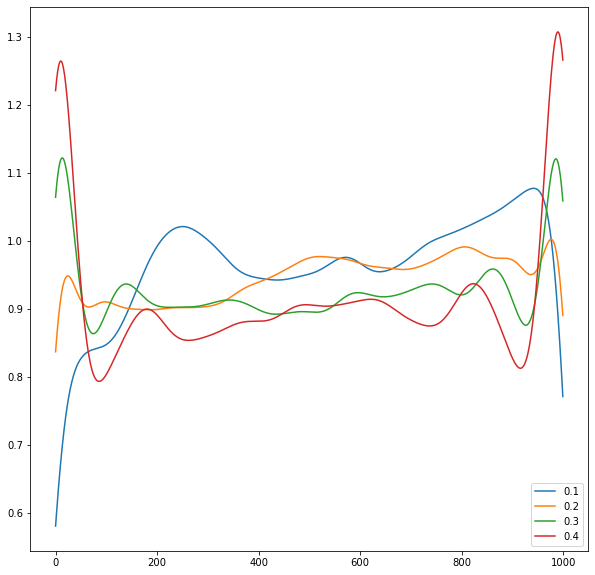

In [17]:
#with ineq
l = len(samples)
fig = plt.figure(figsize=(10,10))
for i,w in enumerate(ws):
    kernel = gaussian_kde(samples2[:,i].reshape(1,l))
    dx = np.linspace(0,1,1000)
    y = kernel.evaluate(dx.T)
    plt.plot(y,label=np.round(w,2))
    plt.legend()

In [54]:
samples3

array([], shape=(1000, 0), dtype=float64)

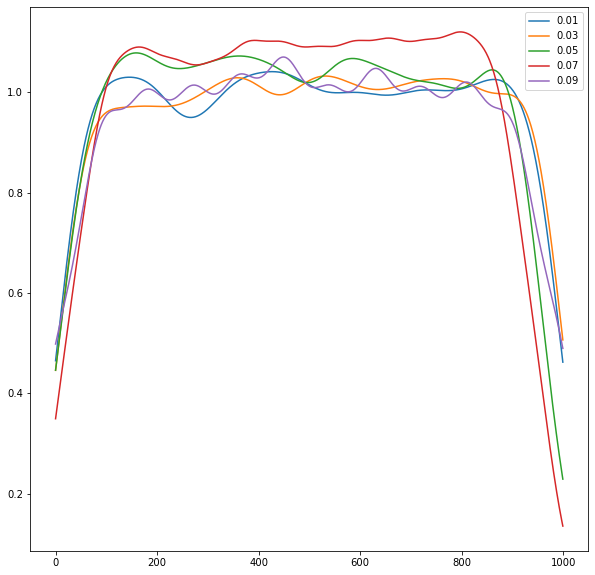

In [57]:
#eq only
n = int(1e4)
ws = np.arange(0.01,0.1,0.02)
samples3 = np.zeros(n*len(ws)).reshape(n,len(ws))
for i,w in enumerate(ws):
    samples3[:,i] = rrt(0,1,w,n,-1,2)

#with ineq
l = len(samples3)
fig = plt.figure(figsize=(10,10))
for i,w in enumerate(ws):
    kernel = gaussian_kde(samples3[:,i].reshape(1,l))
    dx = np.linspace(0,1,1000)
    y = kernel.evaluate(dx.T)
    plt.plot(y,label=np.round(w,2))
    plt.legend()
plt.show()

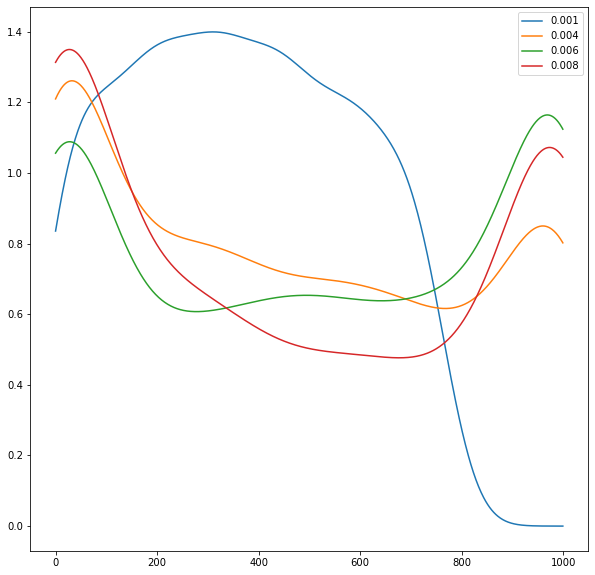

In [51]:
#eq + ineq

n = int(1e3)
ws = np.arange(0.001,0.01,0.0025)
samples3 = np.zeros(n*len(ws)).reshape(n,len(ws))
for i,w in enumerate(ws):
    samples3[:,i] = rrt(0,1,w,n,-0.5,1.5,False)

#with ineq
l = len(samples3)
fig = plt.figure(figsize=(10,10))
for i,w in enumerate(ws):
    kernel = gaussian_kde(samples3[:,i].reshape(1,l))
    dx = np.linspace(0,1,1000)
    y = kernel.evaluate(dx.T)
    plt.plot(y,label=np.round(w,3))
    plt.legend()
plt.show()